In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
from os import path
import xarray as xr
from matplotlib.colors import Normalize, LinearSegmentedColormap
import sys
#sys.path.append('../../')
#from pydicts.obsdict import get_FINO_obs
from mmctools.helper_functions import theta_to_T, lowess_mean, calc_uv,w_s,T_d
from mmctools.wrf.utils import Tower, tsout_seriesReader, write_tslist_file
from mmctools.helper_functions import calc_wind
from mmctools.plotting import TaylorDiagram
import wrf
from netCDF4 import Dataset
import matplotlib.colors as colors
import scipy.stats as stats
import matplotlib.gridspec as gridspec
from scipy.stats import pearsonr
import matplotlib.patches as patches
from string import ascii_lowercase

# Where to save the images:

In [3]:
#save_dir = '/glade/scratch/hawbecke/WRF/ATEC/Chesapeake/20190716to20190801/SST_SENSITIVITY/img/'
save_dir = '/glade/work/hawbecke/ATEC/Chesapeake/SENSITIVITY_STUDY/20190716to20190801/img/'
save_figs = False

# Load the case dictionary file specifying case names, domains, colors, and markers

In [4]:
import sys
sys.path.append('/glade/u/home/hawbecke/Code/Python/')
from publications.Chesapeake.CBB_case_dict import case_dict
cases = list(case_dict.keys())
cases = cases[3:-4]

ncases   = len(cases)
case_dom = [3]*ncases

from publications.Chesapeake.BayBreezeObservedDates import bb_observed_dates
bb_observed_dates = bb_observed_dates['orig']

# Read in buoy data:

In [5]:
obs_f_dir = '/glade/work/hawbecke/ATEC/Chesapeake/Data/Obs/BUOY/'
obs_type = 'combined' # combined or CBIBS or NDBC
#obs_dir = '{}{}/'.format(obs_f_dir,obs_type)
buoy_f = '{}{}_buoy_data_res_2019.nc'.format(obs_f_dir,obs_type)
buoy_ds = xr.open_dataset(buoy_f)

### Buoys PMC, GRF and SRP have bad or no data for this period, CAM, SLM, and WDC are on land

In [6]:
buoy_list = list(buoy_ds.station.data)

bad_buoys = ['PMC','GRF','SRP','WDC','CAM','SLM','JTN']

for bad_buoy in bad_buoys:
    buoy_list.remove(bad_buoy)
buoy_loc_dict = {}
for stn in buoy_list:
    buoy_loc_dict[stn] = {'lat':float(buoy_ds.sel(station=stn).lat.data),
                     'lon':float(buoy_ds.sel(station=stn).lon.data)}

#buoy_loc_dict['JTN']['lat'] = 37.21137
#buoy_loc_dict['JTN']['lon'] = -76.78677

# Get WRF Inland Data:

In [7]:
obs_dir = '/glade/work/hawbecke/ATEC/Chesapeake/Data/Obs/'
awos_ds = xr.open_dataset('{}AWOS/AWOS_2019to2020.nc'.format(obs_dir))
asos_ds = xr.open_dataset('{}ASOS/ASOS_2019to2020.nc'.format(obs_dir))
apg_ds  = xr.open_dataset('{}APG/APG_data_2019.nc'.format(obs_dir))

near_shore_stations  = []
inland_station_names = []
for stn in awos_ds.get_index('station'):
    if awos_ds.sel(station=stn).region.data == 'inland':
        inland_station_names.append(stn)
    if awos_ds.sel(station=stn).region.data == 'coastal':
        near_shore_stations.append(stn)
for stn in asos_ds.get_index('station'):
    if asos_ds.sel(station=stn).region.data == 'inland':
        inland_station_names.append(stn)
    if asos_ds.sel(station=stn).region.data == 'coastal':
        near_shore_stations.append(stn)
for stn in apg_ds.get_index('station'):
    near_shore_stations.append(stn)

near_shore_stations = np.unique(near_shore_stations)
inland_station_names = np.unique(inland_station_names)

# Many stations are missing data - these are the good ones:
near_shore_stations = ['APG', 'BWI', 'MTN', 'NAK', 'NHK', 'NUI']



shallow_buoys = buoy_list.copy()

shallow_buoys.remove('DEB')
shallow_buoys.remove('VAB')

# Extract WRF data at buoy locations

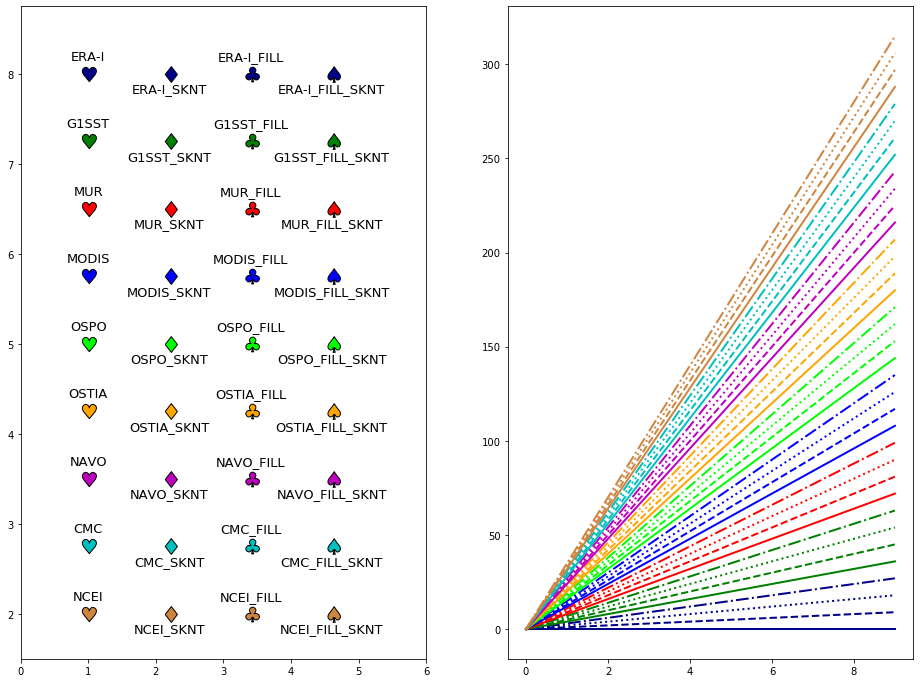

In [8]:
scratch_dir = '/glade/scratch/hawbecke/WRF/ATEC/Chesapeake/20190716to20190801/SST_SENSITIVITY/'
wrf_dir = '/glade/work/hawbecke/ATEC/Chesapeake/SENSITIVITY_STUDY/20190716to20190801/'
#work_dir   = '/glade/work/hawbecke/ATEC/Chesapeake/SENSITIVITY_STUDY/20190716to20190801/'

restarts = ['ERAI_20190715', 'ERAI_20190717', 'ERAI_20190719', 'ERAI_20190721', 
            'ERAI_20190723', 'ERAI_20190725', 'ERAI_20190727', 'ERAI_20190729']

wrf_start  = ['2019-07-15 18:00:00','2019-07-17 18:00:00','2019-07-19 18:00:00','2019-07-21 18:00:00',
              '2019-07-23 18:00:00','2019-07-25 18:00:00','2019-07-27 18:00:00','2019-07-29 18:00:00',]


current_cases_f = glob.glob('{}[CDGMNO]*'.format(wrf_dir))
current_cases = []
for cc in current_cases_f:
    current_case = cc.split('/')[-1]
    if current_case != 'MBDA':
        current_cases.append(current_case)
        
new_cases = []
for case in cases:
    if case in current_cases:
        new_cases.append(case)

x_p = 1
y_p = 8
x = np.arange(0,10)
count = 0
top = True
fig,ax = plt.subplots(figsize=(16,12),ncols=2)
for cc,case in enumerate(cases):
    case_d = case_dict[case]
    for dom_d in case_d:
        plt_d = case_d[dom_d]
        
        if top:
            vadj = 0.12
        else:
            vadj = -0.24
        
        marker_c = plt_d['color']
        marker_e = 'k'


        
        #if not plt_d['fill']:
        #    ax[0].scatter(x_p,y_p,c='k',marker=plt_d['marker'],edgecolors='k',lw=3.0,s=150)
        ax[0].scatter(x_p,y_p,c=marker_c,marker=plt_d['marker'],edgecolors=marker_e,s=250,zorder=3)
        ax[0].text(x_p,y_p+vadj,plt_d['name'],ha='center',va='bottom',size=13)
        x_p += 1.2
        if ('FILL_SKNT' in plt_d['name']):
            x_p = 1
            y_p -= 0.75
            
        
        ax[1].plot(x,x*count,c=plt_d['color'],lw=2.0,ls=plt_d['ls'])
        if top:
            top = False
        else:
            top = True
        count += 1
ax[0].set_ylim(1.5,8.75)    
ax[0].set_xlim(0.0,6.0)
plt.show()

### Read in WRF output at location of buoys

In [9]:
ref_stn = 'IAD'
wrf_twrs = {}
wrf_buoys = {}
for cc,case in enumerate(cases):
    dom = case_dom[cc]
    case_str = '{}_{}'.format(case,'d0{}'.format(dom))
    if dom == 3:
        dt = 9.0
    elif dom == 4:
        dt = 3.0
    else:
        print('Add logic for domain {}'.format(dom))
    print('Starting {} d0{}: time step = {}'.format(case_str,dom,dt))
    

    case_dir = '{}{}/'.format(wrf_dir,case)
    twr_path = '{}{}_d0{}_towers.nc'.format(case_dir,case,dom)    
    if path.exists(twr_path):
        print('loading in full dataset!')
        towers = xr.open_dataset(twr_path)
    else:
        case_dir = '{}{}/'.format(wrf_dir,case)

        towers = tsout_seriesReader(case_dir,restarts,wrf_start,'d0{}'.format(dom),structure='unordered',
                                            time_step=dt,
                                            #select_tower=np.append(near_shore_stations,ref_stn),time_step=dt,
                                            heights=[10.0],height_var='ph')
        towers['temp'] = theta_to_T(towers.theta,towers.pr/100.0)-273.15
        towers['wspd10'],towers['wdir10'] = calc_wind(towers,u='u10',v='v10')
        towers['t2'] += -273.15 
        towers.to_netcdf(twr_path)
    wrf_twrs[case] = towers.sel(station=np.append(near_shore_stations,ref_stn))
    #wrf_buoys[case] = towers.sel(station=buoy_list)


Starting DEFLT_NOFL_NOSK_d03 d03: time step = 9.0
loading in full dataset!
Starting DEFLT_NOFL_SKNT_d03 d03: time step = 9.0
loading in full dataset!
Starting DEFLT_FILL_NOSK_d03 d03: time step = 9.0
loading in full dataset!
Starting DEFLT_FILL_SKNT_d03 d03: time step = 9.0
loading in full dataset!
Starting G1SST_NOFL_NOSK_d03 d03: time step = 9.0
loading in full dataset!
Starting G1SST_NOFL_SKNT_d03 d03: time step = 9.0
loading in full dataset!
Starting G1SST_FILL_NOSK_d03 d03: time step = 9.0
loading in full dataset!
Starting G1SST_FILL_SKNT_d03 d03: time step = 9.0
loading in full dataset!
Starting MUR1K_NOFL_NOSK_d03 d03: time step = 9.0
loading in full dataset!
Starting MUR1K_NOFL_SKNT_d03 d03: time step = 9.0
loading in full dataset!
Starting MUR1K_FILL_NOSK_d03 d03: time step = 9.0
loading in full dataset!
Starting MUR1K_FILL_SKNT_d03 d03: time step = 9.0
loading in full dataset!
Starting MODIS_NOFL_NOSK_d03 d03: time step = 9.0
loading in full dataset!
Starting MODIS_NOFL_SKNT_

In [10]:
wrf_buoys = {}
for cc,case in enumerate(cases[:]):
    new_f_name = '{0}{1}/{1}_extracted_{2}_buoy_data_d0{3}.nc'.format(wrf_dir,case,obs_type,case_dom[cc])
    if path.exists('{}'.format(new_f_name)):
        print('Loading extracted data for {}'.format(new_f_name.split('/')[-1]))
        wrf_buoys[case] = xr.open_dataset('{}'.format(new_f_name))
    else:
        print('Try running ExtractBuoyData.py outside of the notebook to speed things up...')
        print(case, new_f_name)
        get_wrf_locs = True
        rst_dict = {}
        for rr,rst in enumerate(restarts):
            f_list = sorted(glob.glob('{}{}/{}/wrfout_d0{}*'.format(scratch_dir,case,rst,case_dom[cc])))

            if get_wrf_locs:
                wrf_loc_dict = {}
                wrf_i = xr.open_dataset('{}/wrfinput_d0{}'.format('/'.join(f_list[0].split('/')[:-1]),case_dom[cc]))
                is_water = [True]*len(buoy_loc_dict)
                hgt      = np.zeros(len(buoy_loc_dict))
                for ss,stn in enumerate(buoy_loc_dict):
                    #if stn in list(towers.station):
                    wrf_loc_dict[stn] = {}
                    loc_x = int(towers.sel(station=stn).i.data)
                    loc_y = int(towers.sel(station=stn).j.data)
                    # Some buoy locations are on land... grab the water cell next to it
                    stn_landmask = wrf_i.LANDMASK.sel(south_north=loc_y,west_east=loc_x).data
                    if stn_landmask == 1.0:
                        if stn == 'JTN':
                            loc_y -= 1
                        if stn == 'CAM':
                            loc_x -= 1
                            loc_y -= 1

                    wrf_loc_dict[stn]['x'] = loc_x
                    wrf_loc_dict[stn]['y'] = loc_y
                    wrf_stn = wrf_i.sel(south_north=loc_y,west_east=loc_x)
                    wrf_lat = wrf_stn.XLAT
                    wrf_lon = wrf_stn.XLONG
                    landmask = wrf_stn.LANDMASK
                    hgt[ss]  = wrf_stn.HGT
                    if landmask == 1:
                        is_water[ss] = False
                get_wrf_locs = False
                wrf_i.close()
            wrf_times = []
            wspd = np.zeros((len(f_list),len(buoy_loc_dict)))
            wdir = np.zeros((len(f_list),len(buoy_loc_dict)))
            t2   = np.zeros((len(f_list),len(buoy_loc_dict)))
            tsk  = np.zeros((len(f_list),len(buoy_loc_dict)))
            pres = np.zeros((len(f_list),len(buoy_loc_dict)))
            dwpt = np.zeros((len(f_list),len(buoy_loc_dict)))
            sst  = np.zeros((len(f_list),len(buoy_loc_dict)))
            

            for ff,fname in enumerate(f_list):
                print(fname)
                wrf_f = xr.open_dataset(fname)
                wrf_times.append(pd.to_datetime(wrf_f.Times.data[0].decode().replace('_',' ')))
                for ss,stn in enumerate(buoy_loc_dict):
                    u10 = wrf_f.U10.sel(south_north=wrf_loc_dict[stn]['y'],west_east=wrf_loc_dict[stn]['x'])
                    v10 = wrf_f.V10.sel(south_north=wrf_loc_dict[stn]['y'],west_east=wrf_loc_dict[stn]['x'])

                    wspd[ff,ss] = (u10**2 + v10**2)**0.5
                    wdir[ff,ss] = 180. + np.degrees(np.arctan2(u10, v10))
                    t2[ff,ss]   = wrf_f.T2.sel(south_north=wrf_loc_dict[stn]['y'],west_east=wrf_loc_dict[stn]['x'])
                    tsk[ff,ss]  = wrf_f.TSK.sel(south_north=wrf_loc_dict[stn]['y'],west_east=wrf_loc_dict[stn]['x'])
                    pres[ff,ss] = wrf_f.PSFC.sel(south_north=wrf_loc_dict[stn]['y'],west_east=wrf_loc_dict[stn]['x'])/100.0
                    mixingratio = wrf_f.Q2.sel(south_north=wrf_loc_dict[stn]['y'],west_east=wrf_loc_dict[stn]['x'])
                    w_sat       = w_s(t2[ff,ss],pres[ff,ss])
                    rh          = (mixingratio/w_sat)*100.0
                    dwpt[ff,ss] = T_d(t2[ff,ss],rh,celsius=True)
                    sst[ff,ss]  = wrf_f.SST.sel(south_north=wrf_loc_dict[stn]['y'],west_east=wrf_loc_dict[stn]['x'])

                    #try:
                    #    sst[ff,ss]  = wrf_f.SST.sel(south_north=wrf_loc_dict[stn]['y'],west_east=wrf_loc_dict[stn]['x'])
                    #except KeyError:
                    #    if ff == 0 and ss == 0: print('no SST data found... setting to zero')
                    #    sst[ff,ss] = tsk[ff,ss]*0.0
                    

                wrf_f.close()
            rst_dict[rst] = xr.Dataset({'wspd': (['datetime','station'],wspd),
                                        'wdir': (['datetime','station'],wdir),
                                        't2'  : (['datetime','station'],t2),
                                        'tsk' : (['datetime','station'],tsk),
                                        'sst' : (['datetime','station'],sst),
                                        'pres': (['datetime','station'],pres),
                                        'dwpt': (['datetime','station'],dwpt),
                                    'is_water': (['station'],is_water),
                                         'hgt': (['station'],hgt)},
                                        coords={'datetime':wrf_times,
                                                'station': list(buoy_loc_dict.keys())})             
            if rr == 0:
                full_ds = rst_dict[rst]
            else:
                full_ds = full_ds.combine_first(rst_dict[rst])

        full_ds.to_netcdf(new_f_name)
        wrf_buoys[case]  = full_ds


        #fig = plt.figure(figsize=(18,6))
        #full_ds.sel(station='ANN').dwpt.plot(lw=2.0,c='k')
        #for rr,rst in enumerate(rst_dict):
        #    rst_dict[rst].sel(station='ANN').dwpt.plot(lw=1.0)
        #plt.show()
        


Loading extracted data for DEFLT_NOFL_NOSK_extracted_combined_buoy_data_d03.nc
Loading extracted data for DEFLT_NOFL_SKNT_extracted_combined_buoy_data_d03.nc
Loading extracted data for DEFLT_FILL_NOSK_extracted_combined_buoy_data_d03.nc
Loading extracted data for DEFLT_FILL_SKNT_extracted_combined_buoy_data_d03.nc
Loading extracted data for G1SST_NOFL_NOSK_extracted_combined_buoy_data_d03.nc
Loading extracted data for G1SST_NOFL_SKNT_extracted_combined_buoy_data_d03.nc
Loading extracted data for G1SST_FILL_NOSK_extracted_combined_buoy_data_d03.nc
Loading extracted data for G1SST_FILL_SKNT_extracted_combined_buoy_data_d03.nc
Loading extracted data for MUR1K_NOFL_NOSK_extracted_combined_buoy_data_d03.nc
Loading extracted data for MUR1K_NOFL_SKNT_extracted_combined_buoy_data_d03.nc
Loading extracted data for MUR1K_FILL_NOSK_extracted_combined_buoy_data_d03.nc
Loading extracted data for MUR1K_FILL_SKNT_extracted_combined_buoy_data_d03.nc
Loading extracted data for MODIS_NOFL_NOSK_extracted

In [11]:
t_s = wrf_buoys[cases[0]].datetime.data[0] + pd.to_timedelta(12,'h') - pd.to_timedelta(3,'s') # Account for spinup
t_e = wrf_buoys[cases[0]].datetime.data[-1]

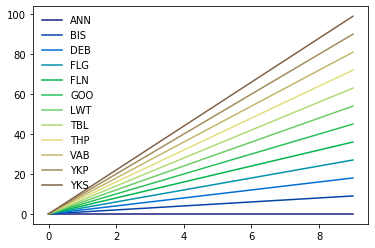

In [12]:
stn_colors = {}
for ss,stn in enumerate(buoy_list):
    line_cols = plt.cm.terrain(np.linspace(0.0,0.7,len(buoy_list)))[ss]
    darken = 0.1
    for tt,col in enumerate(line_cols):
        if tt < 3:
            line_cols[tt] = col - darken
            if line_cols[tt] < 0.0: line_cols[tt] = 0.0
    stn_colors[stn] = line_cols
for ss,stn in enumerate(buoy_list):
    plt.plot(np.arange(0,10),np.arange(0,10)*ss,c=stn_colors[stn],label=stn)
plt.legend(frameon=False)
plt.show()

# Resample obs and WRF to common times:

### FLN has some erroneous data that can be removed:

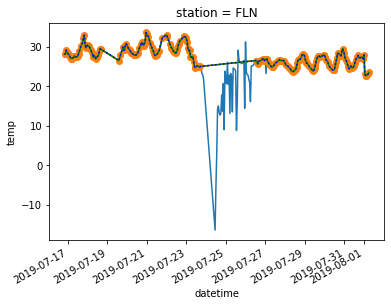

In [13]:
if 'FLN' in buoy_ds.station.data:
    temp_obs = buoy_ds.temp.copy()
    buoy_ds = buoy_ds.drop_vars('temp')

    fln = temp_obs.sel(station='FLN')
    fln.sel(datetime=slice(t_s,t_e)).dropna(how='all',dim='datetime').plot()

    rem_starts = ['2019-07-23 18:00:00','2019-07-27 00:00:00']
    rem_ends  = ['2019-07-26 12:00:00','2019-07-27 01:45:00']


    for rem_s,rem_e in zip(rem_starts,rem_ends):
        fln.sel(datetime=slice(rem_s,rem_e)).data[:] = fln.sel(datetime=slice(rem_s,rem_e)).data[:]*np.nan

    fln.sel(datetime=slice(t_s,t_e)).dropna(how='all',dim='datetime').plot(marker='o')

    temp_obs.sel(station='FLN').data = fln.data

    temp_obs.sel(station='FLN').sel(datetime=slice(t_s,t_e)).dropna(how='all',dim='datetime').plot(c='g')
    buoy_ds['temp'] = temp_obs

    buoy_ds.sel(station='FLN').sel(datetime=slice(t_s,t_e)).temp.dropna(how='all',dim='datetime').plot(c='b',ls=':')
    plt.show()

# Calculate u and v for histograms/scatter plots

In [14]:
buoy_ds['u'],buoy_ds['v'] = calc_uv(buoy_ds)

for cc,case in enumerate(wrf_buoys):
    wrf_buoys[case]['u'],wrf_buoys[case]['v'] = calc_uv(wrf_buoys[case])


# Which variables are going to be compared:

In [15]:
vars_to_compare = { 'sst':'tsk',
                   'temp':'t2',
                   'wspd':'wspd'
                   #'pres':'pres',
                   #'wdir':'wdir',
                   #   'u':'u',
                   #   'v':'v'
                  }

In [16]:
def resample_model_output(stn_ds,buoy_ds,var_dict,adjustments=None,select_stations=None):
    obs_interval = str(np.mean(buoy_ds.datetime.data[1:]-buoy_ds.datetime.data[:-1]).astype('timedelta64[m]')).split(' ')[0]
    obs_interval_str = '{}min'.format(str(obs_interval))

    stn_ds = stn_ds.sel(datetime=slice(buoy_ds.datetime[0],buoy_ds.datetime[-1])).resample(
                                        datetime=obs_interval_str).nearest(tolerance='5s')

    for vv,var in enumerate(var_dict):
        obs_var = var
        stn_var = var_dict[var]

        temp_ds = stn_ds.copy()
        temp_ds.drop_vars(stn_var)
        temp_var = stn_ds[stn_var].copy()
        if adjustments is not None and len(adjustments) == len(var_dict):
            adjustment = adjustments[vv]
            if adjustment is not None:
                print('Adjusting {} by {}'.format(var,adjustment))
                if adjustment[0] == '+' or adjustment[0] == '-':
                    temp_var += float(adjustment)
                elif adjustment[0] == '*':
                    temp_var = temp_var*float(adjustment[1:])
                elif adjustment[0] == '/':
                    temp_var = temp_var/float(adjustment[1:])
                else:
                    print('adjustment {} not understood. Please use +, -, *, or /'.format(adjustments))
        if select_stations is not None:
            station_list = select_stations
        else:
            station_list = stn_ds.station.data
        for ss,stn in enumerate(station_list):
            if type(buoy_ds) == dict:
                obs = buoy_ds[stn]
            elif type(buoy_ds) == xr.core.dataset.Dataset:
                obs = buoy_ds.sel(station=stn)
            else:
                'Need to figure out data type of buoy_ds'
            var = temp_var.sel(station=stn)
            
            var[np.where(np.isnan(obs[obs_var].data))] = var[np.where(np.isnan(obs[obs_var].data))]*np.nan

            temp_var.sel(station=stn).data = var.data

        stn_ds[stn_var] = temp_var
    return(stn_ds)

In [17]:
obs_res = buoy_ds.copy().sel(datetime=slice(t_s,t_e))
obs_res = obs_res.resample(datetime='1h').nearest(tolerance='15m')

wrf_buoys_res = {}
for cc,case in enumerate(wrf_buoys):
    print(case)
    wrf_buoys_res[case] = resample_model_output(wrf_buoys[case].copy().sel(datetime=slice(t_s,t_e)),
                                                obs_res,var_dict=vars_to_compare,
                                                adjustments=['-273.15','-273.15',None])#,None,None,None])
    

DEFLT_NOFL_NOSK
Adjusting sst by -273.15
Adjusting temp by -273.15
DEFLT_NOFL_SKNT
Adjusting sst by -273.15
Adjusting temp by -273.15
DEFLT_FILL_NOSK
Adjusting sst by -273.15
Adjusting temp by -273.15
DEFLT_FILL_SKNT
Adjusting sst by -273.15
Adjusting temp by -273.15
G1SST_NOFL_NOSK
Adjusting sst by -273.15
Adjusting temp by -273.15
G1SST_NOFL_SKNT
Adjusting sst by -273.15
Adjusting temp by -273.15
G1SST_FILL_NOSK
Adjusting sst by -273.15
Adjusting temp by -273.15
G1SST_FILL_SKNT
Adjusting sst by -273.15
Adjusting temp by -273.15
MUR1K_NOFL_NOSK
Adjusting sst by -273.15
Adjusting temp by -273.15
MUR1K_NOFL_SKNT
Adjusting sst by -273.15
Adjusting temp by -273.15
MUR1K_FILL_NOSK
Adjusting sst by -273.15
Adjusting temp by -273.15
MUR1K_FILL_SKNT
Adjusting sst by -273.15
Adjusting temp by -273.15
MODIS_NOFL_NOSK
Adjusting sst by -273.15
Adjusting temp by -273.15
MODIS_NOFL_SKNT
Adjusting sst by -273.15
Adjusting temp by -273.15
MODIS_FILL_NOSK
Adjusting sst by -273.15
Adjusting temp by -27

In [18]:
obs_res['t_diff'] = obs_res.temp - obs_res.sst

for cc,case in enumerate(wrf_buoys):
    wrf_buoys_res[case]['t_diff'] = wrf_buoys_res[case].t2 - wrf_buoys_res[case].tsk


# Taylor Diagrams

In [19]:
remove_mean = False

remove_low_wspds = False
wspd_cutoff = 1.4

remove_night = True
night_hour_s = 22
night_hour_e = 12

only_observed_bb_days = False

TD_stns = list(buoy_list.copy())

TD_stns.remove('DEB') # Remove deep water stations
TD_stns.remove('VAB') # Remove deep water stations
#TD_stns.remove('TBL') # TBL doesn't have wind data...


markers = [(i,j,0) for i in np.arange(2,len(cases)*2) for j in range(1, 2)]
markers = ['o','^','P','X','D','p','d','h','v']

bay_breeze_days_from_obs = []
for meth in bb_observed_dates:
    meth_dates = bb_observed_dates[meth]
    for date in meth_dates:
        bay_breeze_days_from_obs.append(date)
    
bay_breeze_days_from_obs = list(np.unique(bay_breeze_days_from_obs))

#bay_breeze_days_from_obs = ['2019-07-09','2019-07-10','2019-07-11','2019-07-15',
#                            '2019-07-16','2019-07-17','2019-07-19','2019-07-20',
#                            '2019-07-24','2019-07-26','2019-07-27','2019-07-28',
#                            '2019-07-29','2019-07-31']

TD_start = '2019-07-19 00:00:00'
TD_end   = '2019-07-21 00:00:00'

var_str_dict = {'sst':'WST [˚C]',
               'wspd':'Wind Speed [m s$^{-1}$]'}

TD_start = t_s
TD_end   = t_e

In [20]:
cases_of_interest = []
for case in cases:
    if 'NOFL_NOSK' in case:
        cases_of_interest.append(case)
doms_of_interest  = [3]*len(cases_of_interest)

In [21]:
buoy_list_full = buoy_list.copy()

In [22]:
TD_obs_full = {}

for ss,stn in enumerate(buoy_list):
    temp_buoy_ds = obs_res.sel(station=stn).copy()
    for var in vars_to_compare:
        obs_var = var
        temp_buoy_ds.drop_vars(obs_var)
        obs = obs_res.sel(station=stn)[obs_var].copy()
        plt_start_date = pd.to_datetime(obs.datetime.values[0])
        plt_end_date = pd.to_datetime(obs.datetime.values[-1])
        if obs_var == 'wdir':
            obs = np.cos(np.radians(270. - obs))*np.sin(np.radians(270. - obs))
            obs_var = 'wdirA'
            
        if remove_night:
            for day in pd.date_range(start=plt_start_date - pd.to_timedelta(1,'d'), end=plt_end_date):
                night_s = pd.to_datetime('{0}-{1}-{2} {3:02d}:00'.format(day.year,day.month,day.day,night_hour_s))
                night_e = pd.to_datetime('{0}-{1}-{2} {3:02d}:00'.format(day.year,day.month,day.day,night_hour_e)) + pd.Timedelta(1,'d')
                obs.sel(datetime=slice(night_s,night_e)).data[:] = obs.sel(datetime=slice(night_s,night_e)).data*np.nan   
                
        if only_observed_bb_days:
            for day in pd.date_range(start=plt_start_date, end=plt_end_date):
                day_str = '{0}-{1:02d}-{2:02d}'.format(day.year,day.month,day.day)
                if day_str not in bay_breeze_days_from_obs:
                    day_s = pd.to_datetime(day_str)
                    day_e = day_s + pd.Timedelta(1,'d')
                    obs.sel(datetime=slice(day_s,day_e)).data[:] = obs.sel(datetime=slice(day_s,day_e)).data*np.nan
        temp_buoy_ds[obs_var] = obs
        
    TD_obs_full[stn] = temp_buoy_ds
    

TD_wrf_buoys = {}
for cc,case in enumerate(cases):

    temp_twr_ds = wrf_buoys_res[case].copy()

    for vv,var in enumerate(vars_to_compare):
        obs_var = var
        sim_var = vars_to_compare[var]

        if var != 'wdir':
            temp_twr_ds = temp_twr_ds.drop_vars(sim_var)
        
        temp_var = wrf_buoys_res[case][sim_var].copy()
        
        for ss,stn in enumerate(buoy_list):
            
            td_var = temp_var.sel(station=stn)#,datetime=slice(obs.datetime[0],obs.datetime[-1]))

            obs = TD_obs_full[stn][obs_var]
            if var == 'wdir':
                td_var = np.cos(np.radians(270. - td_var))*np.sin(np.radians(270. - td_var))
                sim_var = 'wdirA'
            td_var[np.where(np.isnan(obs))] = np.nan

            if remove_mean: td_var = td_var - td_var(temp_var,2016/32,0)
                           
            temp_var.sel(station=stn).data[:] = td_var.data[:]

        temp_twr_ds[sim_var] = temp_var
    TD_wrf_buoys[case] = temp_twr_ds


# Time Series side x side (SST / wind speed)

In [23]:
TD_obs_full_sub = {}
remove_night_sub = False
for ss,stn in enumerate(buoy_list):
    temp_buoy_ds = obs_res.sel(station=stn).copy()
    for var in vars_to_compare:
        obs_var = var
        temp_buoy_ds.drop_vars(obs_var)
        obs = obs_res.sel(station=stn)[obs_var].copy()

        if obs_var == 'wdir':
            obs = np.cos(np.radians(270. - obs))*np.sin(np.radians(270. - obs))
            obs_var = 'wdirA'
            
        if remove_night_sub:
            for day in pd.date_range(start=plt_start_date - pd.to_timedelta(1,'d'), end=plt_end_date):
                night_s = pd.to_datetime('{0}-{1}-{2} {3:02d}:00'.format(day.year,day.month,day.day,night_hour_s))
                night_e = pd.to_datetime('{0}-{1}-{2} {3:02d}:00'.format(day.year,day.month,day.day,night_hour_e)) + pd.Timedelta(1,'d')
                obs.sel(datetime=slice(night_s,night_e)).data[:] = obs.sel(datetime=slice(night_s,night_e)).data*np.nan   
                
        if only_observed_bb_days:
            for day in pd.date_range(start=plt_start_date, end=plt_end_date):
                day_str = '{0}-{1:02d}-{2:02d}'.format(day.year,day.month,day.day)
                if day_str not in bay_breeze_days_from_obs:
                    day_s = pd.to_datetime(day_str)
                    day_e = day_s + pd.Timedelta(1,'d')
                    obs.sel(datetime=slice(day_s,day_e)).data[:] = obs.sel(datetime=slice(day_s,day_e)).data*np.nan
        temp_buoy_ds[obs_var] = obs
        
    TD_obs_full_sub[stn] = temp_buoy_ds
    

TD_wrf_buoys_sub = {}
for cc,case in enumerate(cases):

    temp_twr_ds = wrf_buoys_res[case].copy()

    for vv,var in enumerate(vars_to_compare):
        obs_var = var
        sim_var = vars_to_compare[var]

        if var != 'wdir':
            temp_twr_ds = temp_twr_ds.drop_vars(sim_var)
        
        temp_var = wrf_buoys_res[case][sim_var].copy()
        
        for ss,stn in enumerate(TD_stns):
            
            td_var = temp_var.sel(station=stn)

            obs = TD_obs_full_sub[stn][obs_var]
                        
            if var == 'wdir':
                td_var = np.cos(np.radians(270. - td_var))*np.sin(np.radians(270. - td_var))
                sim_var = 'wdirA'
            td_var[np.where(np.isnan(obs))] = np.nan

            if remove_mean: td_var = td_var - td_var(temp_var,2016/32,0)
                           
            temp_var.sel(station=stn).data[:] = td_var.data[:]

        temp_twr_ds[sim_var] = temp_var
    TD_wrf_buoys_sub[case] = temp_twr_ds



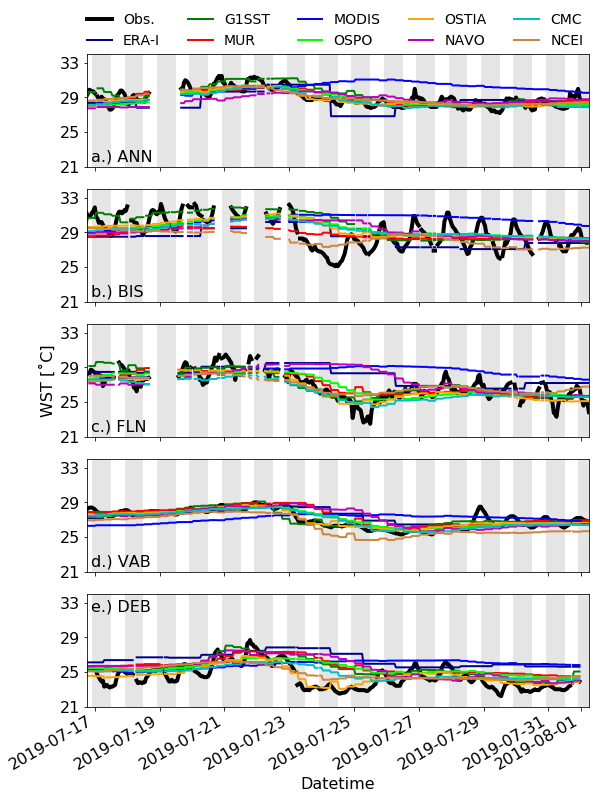

In [24]:
stns_for_plot = ['ANN','BIS','FLN','VAB','DEB']
var = 'sst'
var_str = 'WST [˚C]'

if var != 'wdir':
    obs_var = var
    sim_var = vars_to_compare[var]
else:
    obs_var = '{}A'.format(var)
    sim_var = '{}A'.format(vars_to_compare[var])

fig,ax = plt.subplots(len(stns_for_plot),sharex=True,figsize=(9,12))
for ss,stn in enumerate(stns_for_plot):

    obs = TD_obs_full_sub[stn][obs_var]


    ref_std = np.std(obs.dropna(how='any',dim='datetime').data)

    for cc,case in enumerate(cases_of_interest):
        case_plt_dict = case_dict[case]['d0{}'.format(doms_of_interest[cc])]
        sim = TD_wrf_buoys_sub[case][sim_var].sel(station=stn)

        if cc == 0:
            obs_plt = obs#.dropna(how='any',dim='datetime')
            if len(obs.dropna(how='any',dim='datetime')) > 2:
                obs_plt.plot(ax=ax[ss],c='k',label='Obs.',lw=4.0)#,marker='o')
        if len(sim.dropna(how='any',dim='datetime')) > 2:
            sim_plt = sim#.dropna(how='any',dim='datetime')
            sim_plt.plot(ax=ax[ss],label='{}'.format(case_plt_dict['name']),
                         c=case_plt_dict['color'],ls=case_plt_dict['ls'],
                         lw=2.0)

    ax[ss].set_ylabel(sim_var,size=16)
    if ss == len(TD_stns) - 1:
        ax[ss].set_xlabel('Datetime',size=16)
    else:
        ax[ss].set_xlabel('')
    if ss == 0:
        ax[ss].set_title(var,size=18)
    else:
        ax[ss].set_title('')

    if var == 'wspd':
        ymin,ymax = 0,15
    if var == 'wdir':
        ymin,ymax = 0,0.5
    if var == 'sst':
        ymin,ymax = 21,34
    if var == 'temp':
        ymin,ymax = 15,40
    if var == 'u':
        ymin,ymax = -10,10
    if var == 'v':
        ymin,ymax = -10,10
    if var == 'pres':
        ymin,ymax = 1005,1030

    ax[ss].set_yticks(np.arange(5,46,4))
    ax[ss].set_ylim(ymin,ymax)
    ax[ss].tick_params(labelsize=16)
    if ss == 2:
        ax[ss].set_ylabel(var_str_dict[var],size=16)
    else:
        ax[ss].set_ylabel('')

    ax[ss].set_xlim(sim.datetime.data[0],sim.datetime.data[-1])
#    ax[ss].text(obs.datetime.data[5],ymax + 0.01*(ymax-ymin),stn,va='bottom',ha='left',size=16)
    txt_y = ymin + 0.02*(ymax-ymin)
    if stn == 'DEB': txt_y = ymin + 0.82*(ymax-ymin)
    ax[ss].text(obs.datetime.data[3],txt_y,'{}.) {}'.format(ascii_lowercase[ss],stn),va='bottom',ha='left',size=16)
    plt_start_date = pd.to_datetime(obs.datetime.values[0])
    plt_end_date = pd.to_datetime(obs.datetime.values[-1])
    for day in pd.date_range(start=plt_start_date - pd.to_timedelta(1,'d'), end=plt_end_date):
        night_s = pd.to_datetime('{0:04d}-{1:02d}-{2:02d} {3:02d}:00'.format(day.year,day.month,day.day,night_hour_s))
        night_e = pd.to_datetime('{0:04d}-{1:02d}-{2:02d} {3:02d}:00'.format(day.year,day.month,day.day,night_hour_e)) + pd.Timedelta(1,'d')
        ax[ss].fill_betweenx([-100,400],night_s,night_e,facecolor='k',alpha=0.1)   
ax[0].legend(frameon=False,ncol=5,loc=(-0.01,1.01),fontsize=14,handlelength=1.75)
ax[0].set_title('')
ax[-1].set_xlabel('Datetime',size=16)
figname = '{}WST_Timeseries'.format(save_dir)
if save_figs:
    plt.savefig('{}.png'.format(figname), bbox_inches = 'tight',pad_inches = 0.1)
    plt.savefig('{}.pdf'.format(figname), bbox_inches = 'tight',pad_inches = 0.1)
    print(figname)
plt.show()


## TD diagrams averaged over stations

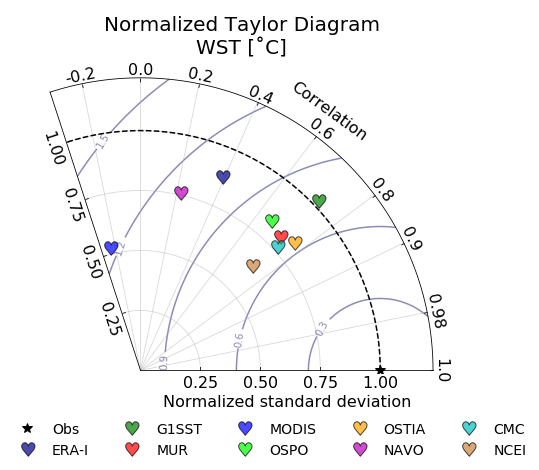

In [25]:
var           = 'sst'
show_each_sample = False

#var           = 'wspd'
#var_str       = 'Wind Speed\n[m s$^{-1}$]'

if var == 'wspd':
    ymin,ymax = 0,15
    ylabel = 'Wind Speed [m s$^{-1}$]'
if var == 'wdir':
    ymin,ymax = 0,0.5
if var == 'sst':
    ymin,ymax = 22,34
    ylabel = 'WST [˚C]'

if var != 'wdir':
    obs_var = var
    sim_var = vars_to_compare[var]

fig = plt.figure(figsize=(7,8))

extend = False
if var == 'pres':
    TD_max_r = 1.3
elif var == 'temp':
    TD_max_r = 1.5
elif var == 'wspd':
    TD_max_r = 1.5
elif var == 'sst':
    TD_max_r = 1.22
    extend = True
else:
    TD_max_r = 1.5
    
dia = TaylorDiagram(1.0, fig=fig, 
                    extend=extend,
                    label='Obs',
                    normalize=True,
                    srange=[0.0,TD_max_r],
                    stdevticks=np.arange(0.25,5.6,0.25),
                    labelsize=16,
                    corrticks=[0.0,0.2,0.4,0.6,0.8,0.9,0.98,1.0],
                    extend_length=np.pi*0.6)
td_stats = {}


for cc,case in enumerate(cases_of_interest):
    case_plt_dict = case_dict[case]['d0{}'.format(doms_of_interest[cc])]
    td_stats[case] = pd.DataFrame(index=TD_stns, columns=['std_norm','R2'], dtype=float) 

    for ss,stn in enumerate(TD_stns):

        obs = TD_obs_full[stn][obs_var]
        obs = obs.dropna(how='any',dim='datetime')
        sim = TD_wrf_buoys_sub[case][sim_var].sel(station=stn,datetime=obs.datetime)
        sim = sim.dropna(how='any',dim='datetime')

        ref_std = np.std(obs.data)
        sim_std = np.std(sim.data)

        r2,_ = pearsonr(sim, obs)

        if ss == 0: 
            obs_full = obs - np.nanmean(obs)
            sim_full = sim - np.nanmean(sim)
            #label_str = '_'.join(case.replace('_KF','').split('_')[1:])
            label_str = None
        else:
            obs_full = np.concatenate([obs_full,obs - np.nanmean(obs)])
            sim_full = np.concatenate([sim_full,sim - np.nanmean(sim)])
            label_str = None
        #print(case,stn,np.std(sim.data)/ref_std)
        marker_c = stn_colors[stn]
        marker_e = 'k'


        td_stats[case].loc[stn,'std_norm'] = sim_std/ref_std
        td_stats[case].loc[stn,'R2'] = r2

        if show_each_sample:
            dia.set_ref(ref_std)
            dia.add_sample(np.std(sim.data), r2,
                           marker=case_plt_dict['marker'], ms=8, ls='',
                           mfc=marker_c, mec=marker_e, # Colors
                           label=label_str,
                           zorder=cc,alpha=0.2)

    multimodal_mean = False

    if multimodal_mean:
        ref_std_full = np.std(obs_full)

        dia.add_sample(np.std(sim_full)/ref_std_full, np.corrcoef(sim_full,obs_full)[0,1],
               marker=case_plt_dict['marker'], ms=15, ls='',
               mfc=case_plt_dict['color'], mec='k', # Colors
               label=case_plt_dict['name'],
               zorder=cc+3,alpha=0.7)
    else:        
        td_stats[case]['angle'] = np.arccos(td_stats[case]['R2'])
        td_mean = td_stats[case].mean(axis=0)
        dia.add_sample(td_mean['std_norm'], np.cos(td_mean['angle']),
               norm=False, # don't normalize this point
               marker=case_plt_dict['marker'], ms=15, ls='',
               mfc=case_plt_dict['color'], mec='k', # Colors
               label=case_plt_dict['name'],
               zorder=cc+3,alpha=0.7)
contours = dia.add_contours(levels=5, colors='midnightblue',alpha=0.50,zorder=1)
dia.ax.clabel(contours, inline=1, fontsize=10, fmt='%.1f')
dia.add_grid(alpha=0.5)
plt.legend(frameon=False,fontsize=14,loc=(-0.1,-0.3),ncol=5)
plt.title('Normalized Taylor Diagram\n{}'.format(''.join(ylabel.split('\n')[0])),size=20,y=1.05)
#plt.text(-0.05,2.65,'e.)',size=16,ha='right')
figname = '{}WST_TD'.format(save_dir)
if save_figs:
    plt.savefig('{}.png'.format(figname), bbox_inches = 'tight',pad_inches = 0.1)
    plt.savefig('{}.pdf'.format(figname), bbox_inches = 'tight',pad_inches = 0.1)
    print(figname)
plt.show()

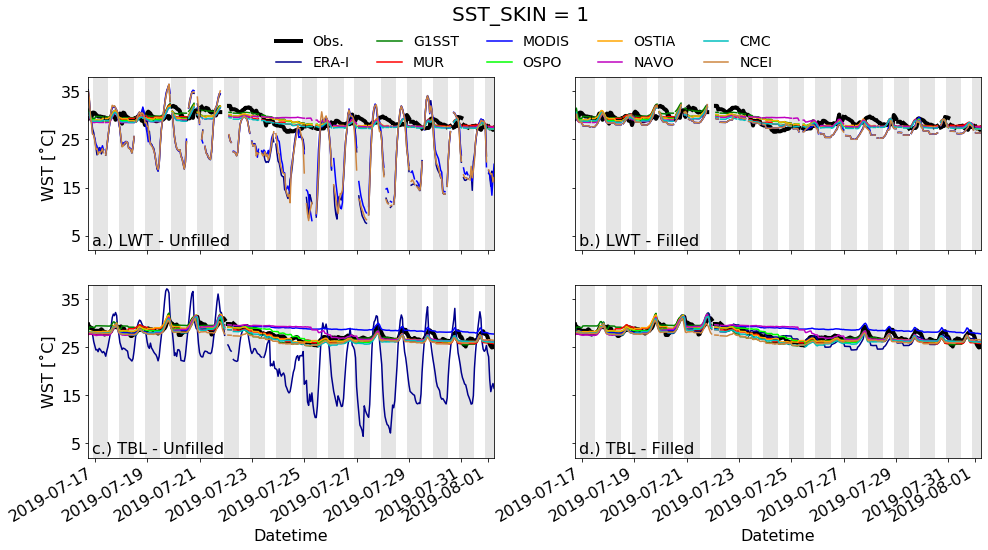

In [26]:
case_set1 = []
case_set2 = []
for case in cases:
    if 'NOFL_SKNT' in case:
        case_set1.append(case)
    elif 'FILL_SKNT' in case:
        case_set2.append(case)
        
doms_of_interest  = [3]*len(case_set1)


stns_for_plot = ['LWT','TBL']
var = 'sst'
var_str = 'WST [˚C]'

if var != 'wdir':
    obs_var = var
    sim_var = vars_to_compare[var]
else:
    obs_var = '{}A'.format(var)
    sim_var = '{}A'.format(vars_to_compare[var])

fig,ax = plt.subplots(nrows=2,ncols=2,sharex=True,sharey=True,figsize=(16,7))

for ss,stn in enumerate(stns_for_plot):

    obs = TD_obs_full_sub[stn][obs_var]


    ref_std = np.std(obs.dropna(how='any',dim='datetime').data)

    for cc,case in enumerate(case_set1):
        case_plt_dict = case_dict[case]['d0{}'.format(doms_of_interest[cc])]
        sim = TD_wrf_buoys_sub[case][sim_var].sel(station=stn)

        if cc == 0:
            obs_plt = obs#.dropna(how='any',dim='datetime')
            if len(obs.dropna(how='any',dim='datetime')) > 2:
                obs_plt.plot(ax=ax[ss,0],c='k',label='Obs.',lw=4.0)#,marker='o')
        if len(sim.dropna(how='any',dim='datetime')) > 2:
            sim_plt = sim#.dropna(how='any',dim='datetime')
            sim_plt.plot(ax=ax[ss,0],label='{}'.format(case_plt_dict['name'].split('_')[0]),
                         c=case_plt_dict['color'],
                         #ls=case_plt_dict['ls'])
                         ls='-')
    for cc,case in enumerate(case_set2):
        case_plt_dict = case_dict[case]['d0{}'.format(doms_of_interest[cc])]
        sim = TD_wrf_buoys_sub[case][sim_var].sel(station=stn)

        if cc == 0:
            obs_plt = obs#.dropna(how='any',dim='datetime')
            if len(obs.dropna(how='any',dim='datetime')) > 2:
                obs_plt.plot(ax=ax[ss,1],c='k',label='Obs.',lw=4.0)#,marker='o')
        if len(sim.dropna(how='any',dim='datetime')) > 2:
            sim_plt = sim#.dropna(how='any',dim='datetime')
            sim_plt.plot(ax=ax[ss,1],label='{}'.format(case_plt_dict['name'].split('_')[0]),
                         c=case_plt_dict['color'],
                         #ls=case_plt_dict['ls'])
                         ls='-')
            

    ax[ss,0].set_ylabel(sim_var,size=16)
    if ss == len(TD_stns) - 1:
        ax[ss,0].set_xlabel('Datetime',size=16)
        ax[ss,1].set_xlabel('Datetime',size=16)
    else:
        ax[ss,0].set_xlabel('')
        ax[ss,1].set_xlabel('')
    if ss == 0:
        ax[ss,0].set_title('',size=18)
        ax[ss,1].set_title('',size=18)
    else:
        ax[ss,0].set_title('')
        ax[ss,1].set_title('')

    if var == 'wspd':
        ymin,ymax = 0,15
    if var == 'wdir':
        ymin,ymax = 0,0.5
    if var == 'sst':
        ymin,ymax = 2,38
    if var == 'temp':
        ymin,ymax = 15,40
    if var == 'u':
        ymin,ymax = -10,10
    if var == 'v':
        ymin,ymax = -10,10
    if var == 'pres':
        ymin,ymax = 1005,1030

    for axi in range(0,2):
        ax[ss,axi].set_yticks(np.arange(5,46,10))
        ax[ss,axi].set_ylim(ymin,ymax)
        ax[ss,axi].tick_params(labelsize=16)

    ax[ss,0].set_xlim(sim.datetime.data[0],sim.datetime.data[-1])

    plt_start_date = pd.to_datetime(obs.datetime.values[0])
    plt_end_date = pd.to_datetime(obs.datetime.values[-1])
    for day in pd.date_range(start=plt_start_date - pd.to_timedelta(1,'d'), end=plt_end_date):
        night_s = pd.to_datetime('{0:04d}-{1:02d}-{2:02d} {3:02d}:00'.format(day.year,day.month,day.day,night_hour_s))
        night_e = pd.to_datetime('{0:04d}-{1:02d}-{2:02d} {3:02d}:00'.format(day.year,day.month,day.day,night_hour_e)) + pd.Timedelta(1,'d')
        ax[ss,0].fill_betweenx([-100,400],night_s,night_e,facecolor='k',alpha=0.1)   
        ax[ss,1].fill_betweenx([-100,400],night_s,night_e,facecolor='k',alpha=0.1)   
ax[0,0].legend(frameon=False,ncol=5,loc=(0.45,1.01),fontsize=14,handlelength=1.75)
ax[0,0].set_title('')
ax[0,1].set_title('')
ax[1,0].set_xlabel('Datetime',size=16)
ax[1,1].set_xlabel('Datetime',size=16)

txt_ind = 0
for col in range(0,2):
    for row in range(0,2):
        
        if col == 0:
            ax[row,col].set_ylabel(var_str_dict[var],size=16)
        else:
            ax[row,col].set_ylabel('')
        
        if row == 0:
            plt_lbl = '{}.) {} - Unfilled'.format(ascii_lowercase[txt_ind],stns_for_plot[col])
        if row == 1:
            plt_lbl = '{}.) {} - Filled'.format(ascii_lowercase[txt_ind],stns_for_plot[col])
        ax[col,row].text(0.01,0.01,
                         plt_lbl,
                         va='bottom',ha='left',size=16,
                         transform=ax[col,row].transAxes)
        txt_ind += 1

plt.suptitle('SST_SKIN = 1',size=20,y=1.02)
figname = '{}WST_Fill_Compare_Timeseries'.format(save_dir)
if save_figs:
    plt.savefig('{}.png'.format(figname), bbox_inches = 'tight',pad_inches = 0.1)
    plt.savefig('{}.pdf'.format(figname), bbox_inches = 'tight',pad_inches = 0.1)
    print(figname)
plt.show()

# 2-D Histograms

In [27]:
def create_2dHistogram(varA,varB,n_binsA,n_binsB):
    '''
    Returns the x, y, and z arrays to plot a 2-D histogram
    given two variables, A (x-axis) and B (y-axis).
    To call:
    x,y,z = create_2dHistogram(variableA,variableB,number_of_bins)
    To plot, call:
    plt.pcolormesh(x,y, z,norm=colors.LogNorm(vmin=1e-2,vmax=hist2d.max()))
    '''
    varA_flat = varA.flatten()
    varB_flat = varB.flatten()
    varA_vs_varB, ab_xedges, ab_yedges = np.histogram2d(varA_flat, varB_flat, bins=[n_binsA,n_binsB])
    x_2d, y_2d = np.meshgrid(ab_xedges,ab_yedges)
    return(x_2d,y_2d,varA_vs_varB.T)

In [28]:
cases_of_interest = cases.copy()
doms_of_interest = case_dom.copy()

cases_of_interest = []
cases_for_2D_hist = ['DEFLT','OSTIA']
for cc,case in enumerate(cases):
    if (cases_for_2D_hist[0] in case) or (cases_for_2D_hist[1] in case): cases_of_interest.append(case)
print(cases_of_interest)
doms_of_interest = [3]*len(cases_of_interest)

['DEFLT_NOFL_NOSK', 'DEFLT_NOFL_SKNT', 'DEFLT_FILL_NOSK', 'DEFLT_FILL_SKNT', 'OSTIA_NOFL_NOSK', 'OSTIA_NOFL_SKNT', 'OSTIA_FILL_NOSK', 'OSTIA_FILL_SKNT']


In [29]:
save_figs = False

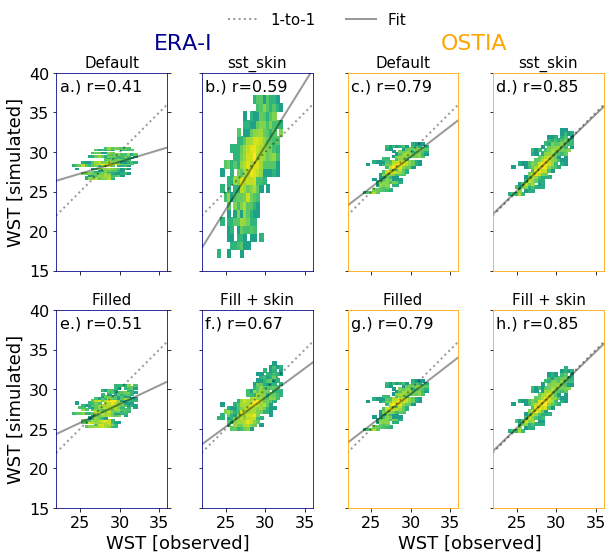

In [30]:
obs_var = var
sim_var = vars_to_compare[var]
if var == 'sst'    : var_str = 'WST'
if var == 'wspd'   : var_str = 'Wind Speed'
if var == 'temp'   : var_str = '2 m Temperature'
if var == 'pres'   : var_str = 'Surface Pressure'
if var == 't_diff' : var_str = '∆T'
fig,ax = plt.subplots(nrows=2,ncols=4,figsize=(10,8),sharey=True,sharex=True)
row = 0
col = 0
case_performance_dict = {}
case_count = 0
row_start = 0
col_start = 0
case_subcount = 1
for cc,case in enumerate(cases_of_interest):
    for ss,stn in enumerate(TD_stns):

        obs = TD_obs_full[stn][obs_var]
        obs = obs.dropna(how='any',dim='datetime')

        case_plt_dict = case_dict[case]['d0{}'.format(doms_of_interest[cc])]
        sim = TD_wrf_buoys[case][sim_var].sel(station=stn)
        sim = sim.dropna(how='any',dim='datetime')

        varB = sim.data
        varA = obs.data

        if ss == 0:
            varA_f = varA
            varB_f = varB
        else:
            varA_f = np.concatenate((varA_f,varA))
            varB_f = np.concatenate((varB_f,varB))
    if (len(varA_f) == len(varB_f)) and (len(varA_f) > 2):
        slope, intercept, r_value, p_value, std_err = stats.linregress(varA_f, varB_f)
        x2d,y2d,hist2d = create_2dHistogram(varA_f,varB_f,20,20)

        ax[row,col].pcolormesh(x2d,y2d, hist2d,norm=colors.LogNorm(vmin=1e-2,vmax=hist2d.max()),rasterized=True)




    ref_x = np.arange(-1000,1001)
    if cc == 0:
        line_lbl1 = '1-to-1'
        line_lbl2 = 'Fit'
    else:
        line_lbl1 = None
        line_lbl2 = None
    xmin,xmax = 22,36
    ymin,ymax = 15,40
    xtick_min,xtick_max,xtick_int = 10,42,5
    ytick_min,ytick_max,ytick_int = 10,42,5
    
    ax[row,col].plot(ref_x,ref_x,c='k',lw=2.0,alpha=0.4,ls=':',label=line_lbl1)
    ax[row,col].plot(ref_x,slope*ref_x + intercept,c='k',lw=2.0,alpha=0.4,label=line_lbl2)
    if cc == 0: ax[0,0].legend(frameon=False,loc=(1.5,1.2),fontsize=15,ncol=2)
    plt_num = '{}{}'.format(ascii_lowercase[case_count],case_subcount)
    txt_va = 'top'
    txt_y = 0.97
    plts_with_bottom_text = []
    if  plt_num in plts_with_bottom_text:
        txt_y = 0.02
        txt_va='bottom'
    lbl_num = row*4 + col
    ax[row,col].text(0.03,txt_y,'{1}.) r={0:3.2f}'.format(r_value,ascii_lowercase[lbl_num]), 
                     size=16,va=txt_va,
                     transform=ax[row,col].transAxes)
    
    
    ['Default','sst_skin','Filled','Fill + skin']
    if 'FILL_SKNT' in case_plt_dict['name']:
        plt_title = 'Fill + skin'
    elif 'FILL' in case_plt_dict['name']:
        plt_title = 'Filled'
    elif 'SKNT' in case_plt_dict['name']:
        plt_title = 'sst_skin'
    else:
        plt_title = 'Default'


    ax[row,col].set_title(plt_title,size=15)
    ax[row,col].tick_params(labelsize=16)

    
    
    ax[row,col].set_xticks(np.arange(xtick_min,xtick_max+1,xtick_int))
    ax[row,col].set_yticks(np.arange(ytick_min,ytick_max+1,ytick_int))
    ax[row,col].set_xlim(xmin,xmax)
    ax[row,col].set_ylim(ymin,ymax)
    ax[row,col].set_aspect('equal')
    
    
    case_performance_dict[case] = r_value

    # Row, col logic - - - - - - - - - - - - - - - - - 
    if (((cc+1)/4.0 - np.round((cc+1)/4.0)) == 0.0):
        case_count += 1
        case_subcount = 1
        col_start += 2

        if (((case_count)/3.0 - np.round((case_count)/3.0)) == 0.0):
            row_start += 2
            col_start = 0
        row = row_start
        col = col_start
    else:
        case_subcount += 1
        col += 1
        if col == col_start + 2:
            col = col_start
            row += 1
        if row == row_start + 2:
            row = row_start
    # - - - - - - - - - - - - - - - - - - - - - - - - - 


sorted_performance = dict(sorted(case_performance_dict.items(), key=lambda x: x[1]))
row = 0
col = 0
case_count = 0
row_start = 0
col_start = 0
for cc,case in enumerate(cases_of_interest):
    case_plt_dict = case_dict[case]['d0{}'.format(doms_of_interest[cc])]
    plt.setp(ax[row,col].spines.values(), color=case_plt_dict['color'])
    #elif case in list(sorted_performance.keys())[-6:]:
    #    plt.setp(ax[row,col].spines.values(), color='b')
    # Row, col logic - - - - - - - - - - - - - - - - - 
    if (((cc+1)/4.0 - np.round((cc+1)/4.0)) == 0.0):
        case_count += 1
        col_start += 2

        if (((case_count)/3.0 - np.round((case_count)/3.0)) == 0.0):
            row_start += 2
            col_start = 0
        row = row_start
        col = col_start
    else:

        col += 1
        if col == col_start + 2:
            col = col_start
            row += 1
        if row == row_start + 2:
            row = row_start
    # - - - - - - - - - - - - - - - - - - - - - - - - - 

#ax[4,0].set_visible(False)
#ax[4,1].set_visible(False)
for axi in range(0,2):
    ax[axi,0].set_ylabel('{} [simulated]'.format(var_str),size=18)#,y=1.3)
    ax[axi,0].tick_params(right=True)
    case_plt_dict = case_dict[cases_for_2D_hist[axi]+'_NOFL_NOSK']['d0{}'.format(doms_of_interest[axi])]
    plt.text(1.14,1.1,case_plt_dict['name'],size=22, 
             transform=ax[0,axi*2].transAxes,va='bottom',ha='center',
             c=case_plt_dict['color'])

    
ax[1,0].set_xlabel('{} [observed]'.format(var_str),size=18,x=1.1)
ax[1,2].set_xlabel('{} [observed]'.format(var_str),size=18,x=1.1)



figname = '{}WST_2Dhist_ERA_OSTIA'.format(save_dir)
if save_figs:
    plt.savefig('{}.png'.format(figname), bbox_inches = 'tight',pad_inches = 0.1)
    plt.savefig('{}.pdf'.format(figname), bbox_inches = 'tight',pad_inches = 0.1)
    print(figname)
plt.show()


IndexError: index 2 is out of bounds for axis 1 with size 2

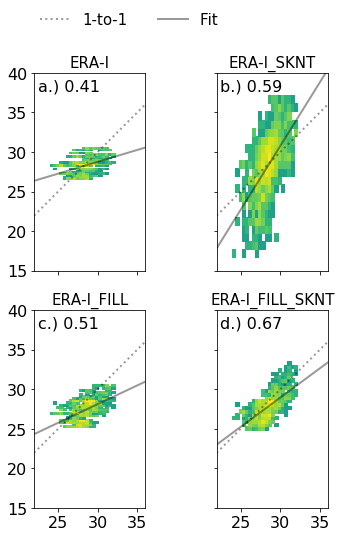

In [31]:
obs_var = var
sim_var = vars_to_compare[var]
if var == 'sst'    : var_str = 'WST'
if var == 'wspd'   : var_str = 'Wind Speed'
if var == 'temp'   : var_str = '2 m Temperature'
if var == 'pres'   : var_str = 'Surface Pressure'
if var == 't_diff' : var_str = '∆T'
fig,ax = plt.subplots(nrows=2,ncols=2,figsize=(6,8),sharey=True,sharex=True)
row = 0
col = 0
case_performance_dict = {}
case_count = 0
row_start = 0
col_start = 0
case_subcount = 1
for cc,case in enumerate(cases_of_interest):
    for ss,stn in enumerate(TD_stns):

        obs = TD_obs_full[stn][obs_var]
        obs = obs.dropna(how='any',dim='datetime')

        case_plt_dict = case_dict[case]['d0{}'.format(doms_of_interest[cc])]
        sim = TD_wrf_buoys[case][sim_var].sel(station=stn)
        sim = sim.dropna(how='any',dim='datetime')

        varB = sim.data
        varA = obs.data

        if ss == 0:
            varA_f = varA
            varB_f = varB
        else:
            varA_f = np.concatenate((varA_f,varA))
            varB_f = np.concatenate((varB_f,varB))
    if (len(varA_f) == len(varB_f)) and (len(varA_f) > 2):
        slope, intercept, r_value, p_value, std_err = stats.linregress(varA_f, varB_f)
        x2d,y2d,hist2d = create_2dHistogram(varA_f,varB_f,20,20)

        ax[row,col].pcolormesh(x2d,y2d, hist2d,norm=colors.LogNorm(vmin=1e-2,vmax=hist2d.max()),rasterized=True)




    ref_x = np.arange(-1000,1001)
    if cc == 0:
        line_lbl1 = '1-to-1'
        line_lbl2 = 'Fit'
    else:
        line_lbl1 = None
        line_lbl2 = None
    xmin,xmax = 22,36
    ymin,ymax = 15,40
    xtick_min,xtick_max,xtick_int = 10,42,5
    ytick_min,ytick_max,ytick_int = 10,42,5
    
    ax[row,col].plot(ref_x,ref_x,c='k',lw=2.0,alpha=0.4,ls=':',label=line_lbl1)
    ax[row,col].plot(ref_x,slope*ref_x + intercept,c='k',lw=2.0,alpha=0.4,label=line_lbl2)
    if cc == 0: ax[0,0].legend(frameon=False,loc=(0.0,1.2),fontsize=15,ncol=2)
    plt_num = '{}{}'.format(ascii_lowercase[case_count],case_subcount)
    txt_va = 'top'
    txt_y = 0.97
    plts_with_bottom_text = []
    if  plt_num in plts_with_bottom_text:
        txt_y = 0.02
        txt_va='bottom'
    ax[row,col].text(0.03,txt_y,'{1}.) {0:3.2f}'.format(r_value,ascii_lowercase[cc]), 
                     size=16,va=txt_va,
                     transform=ax[row,col].transAxes)
    ax[row,col].set_title(case_plt_dict['name'],size=15)
    ax[row,col].tick_params(labelsize=16)

    
    
    ax[row,col].set_xticks(np.arange(xtick_min,xtick_max+1,xtick_int))
    ax[row,col].set_yticks(np.arange(ytick_min,ytick_max+1,ytick_int))
    ax[row,col].set_xlim(xmin,xmax)
    ax[row,col].set_ylim(ymin,ymax)
    ax[row,col].set_aspect('equal')
    
    
    case_performance_dict[case] = r_value

    # Row, col logic - - - - - - - - - - - - - - - - - 
    if (((cc+1)/4.0 - np.round((cc+1)/4.0)) == 0.0):
        case_count += 1
        case_subcount = 1
        col_start += 2

        if (((case_count)/3.0 - np.round((case_count)/3.0)) == 0.0):
            row_start += 2
            col_start = 0
        row = row_start
        col = col_start
    else:
        case_subcount += 1
        col += 1
        if col == col_start + 2:
            col = col_start
            row += 1
        if row == row_start + 2:
            row = row_start
    # - - - - - - - - - - - - - - - - - - - - - - - - - 

'''
sorted_performance = dict(sorted(case_performance_dict.items(), key=lambda x: x[1]))
row = 0
col = 0
case_count = 0
row_start = 0
col_start = 0
for cc,case in enumerate(cases_of_interest):
    if case in list(sorted_performance.keys())[:6]:
        plt.setp(ax[row,col].spines.values(), color='r')
    elif case in list(sorted_performance.keys())[-6:]:
        plt.setp(ax[row,col].spines.values(), color='b')
    # Row, col logic - - - - - - - - - - - - - - - - - 
    if (((cc+1)/4.0 - np.round((cc+1)/4.0)) == 0.0):
        case_count += 1
        col_start += 2

        if (((case_count)/3.0 - np.round((case_count)/3.0)) == 0.0):
            row_start += 2
            col_start = 0
        row = row_start
        col = col_start
    else:

        col += 1
        if col == col_start + 2:
            col = col_start
            row += 1
        if row == row_start + 2:
            row = row_start
    # - - - - - - - - - - - - - - - - - - - - - - - - - 
'''
#ax[4,0].set_visible(False)
#ax[4,1].set_visible(False)
for axi in range(0,2):
    ax[axi,0].set_ylabel('{} [simulated]'.format(var_str),size=18)#,y=1.3)
    ax[axi,0].tick_params(right=True)
    ax[1,axi].set_xlabel('{} [observed]'.format(var_str),size=18)#,x=1.1)

figname = '{}WST_2Dhist_equal'.format(save_dir)
if save_figs:
    plt.savefig('{}.png'.format(figname), bbox_inches = 'tight',pad_inches = 0.1)
    plt.savefig('{}.pdf'.format(figname), bbox_inches = 'tight',pad_inches = 0.1)
    print(figname)
plt.show()


In [ ]:
obs_var = var
sim_var = vars_to_compare[var]
if var == 'sst'    : var_str = 'WST'
if var == 'wspd'   : var_str = 'Wind Speed'
if var == 'temp'   : var_str = '2 m Temperature'
if var == 'pres'   : var_str = 'Surface Pressure'
if var == 't_diff' : var_str = '∆T'
fig,ax = plt.subplots(nrows=6,ncols=6,figsize=(14,19),sharey=True,sharex=True)
row = 0
col = 0
case_performance_dict = {}
case_count = 0
row_start = 0
col_start = 0
case_subcount = 1
for cc,case in enumerate(cases_of_interest):

    for ss,stn in enumerate(TD_stns):

        obs = TD_obs_full[stn][obs_var]
        obs = obs.dropna(how='any',dim='datetime')

        case_plt_dict = case_dict[case]['d0{}'.format(doms_of_interest[cc])]
        sim = TD_wrf_buoys[case][sim_var].sel(station=stn)
        sim = sim.dropna(how='any',dim='datetime')

        varB = sim.data
        varA = obs.data

        if ss == 0:
            varA_f = varA
            varB_f = varB
        else:
            varA_f = np.concatenate((varA_f,varA))
            varB_f = np.concatenate((varB_f,varB))
    if (len(varA_f) == len(varB_f)) and (len(varA_f) > 2):
        slope, intercept, r_value, p_value, std_err = stats.linregress(varA_f, varB_f)
        x2d,y2d,hist2d = create_2dHistogram(varA_f,varB_f,20,20)

        ax[row,col].pcolormesh(x2d,y2d, hist2d,norm=colors.LogNorm(vmin=1e-2,vmax=hist2d.max()),rasterized=True)




    ref_x = np.arange(-1000,1001)
    if cc == 0:
        line_lbl1 = '1-to-1'
        line_lbl2 = 'Fit'
    else:
        line_lbl1 = None
        line_lbl2 = None
    xmin,xmax = 22,36
    ymin,ymax = 18,38
    xtick_min,xtick_max,xtick_int = 10,42,5
    ytick_min,ytick_max,ytick_int = 10,42,5
    
    ax[row,col].plot(ref_x,ref_x,c='k',lw=2.0,alpha=0.4,ls=':',label=line_lbl1)
    ax[row,col].plot(ref_x,slope*ref_x + intercept,c='k',lw=2.0,alpha=0.4,label=line_lbl2)
    if cc == 0: ax[0,0].legend(frameon=False,loc=(0.0,1.2),fontsize=15,ncol=2)
    plt_num = '{}{}'.format(ascii_lowercase[case_count],case_subcount)
    txt_va = 'top'
    txt_y = 0.97
    plts_with_bottom_text = ['d2','a2','i2']
    if  plt_num in plts_with_bottom_text:
        txt_y = 0.02
        txt_va='bottom'
    ax[row,col].text(0.03,txt_y,'{1}.) {0:3.2f}'.format(r_value,plt_num), 
                     size=16,va=txt_va,
                     transform=ax[row,col].transAxes)
    ax[row,col].set_title(case_plt_dict['name'],size=15)
    ax[row,col].tick_params(labelsize=16)

    
    
    ax[row,col].set_xticks(np.arange(xtick_min,xtick_max+1,xtick_int))
    ax[row,col].set_yticks(np.arange(ytick_min,ytick_max+1,ytick_int))
    ax[row,col].set_xlim(xmin,xmax)
    ax[row,col].set_ylim(ymin,ymax)
    ax[row,col].set_aspect('equal')
    
    
    case_performance_dict[case] = r_value

    # Row, col logic - - - - - - - - - - - - - - - - - 
    if (((cc+1)/4.0 - np.round((cc+1)/4.0)) == 0.0):
        case_count += 1
        case_subcount = 1
        col_start += 2

        if (((case_count)/3.0 - np.round((case_count)/3.0)) == 0.0):
            row_start += 2
            col_start = 0
        row = row_start
        col = col_start
    else:
        case_subcount += 1
        col += 1
        if col == col_start + 2:
            col = col_start
            row += 1
        if row == row_start + 2:
            row = row_start
    # - - - - - - - - - - - - - - - - - - - - - - - - - 


sorted_performance = dict(sorted(case_performance_dict.items(), key=lambda x: x[1]))
row = 0
col = 0
case_count = 0
row_start = 0
col_start = 0
for cc,case in enumerate(cases_of_interest):
    if case in list(sorted_performance.keys())[:6]:
        plt.setp(ax[row,col].spines.values(), color='r')
    elif case in list(sorted_performance.keys())[-6:]:
        plt.setp(ax[row,col].spines.values(), color='b')
    # Row, col logic - - - - - - - - - - - - - - - - - 
    if (((cc+1)/4.0 - np.round((cc+1)/4.0)) == 0.0):
        case_count += 1
        col_start += 2

        if (((case_count)/3.0 - np.round((case_count)/3.0)) == 0.0):
            row_start += 2
            col_start = 0
        row = row_start
        col = col_start
    else:

        col += 1
        if col == col_start + 2:
            col = col_start
            row += 1
        if row == row_start + 2:
            row = row_start
    # - - - - - - - - - - - - - - - - - - - - - - - - - 
#ax[4,0].set_visible(False)
#ax[4,1].set_visible(False)
ax[3,0].set_ylabel('{} [simulated]'.format(var_str),size=18,y=1.3)
ax[5,2].set_xlabel('{} [observed]'.format(var_str),size=18,x=1.1)

figname = '{}WST_2Dhist_equal'.format(save_dir)
if save_figs:
    plt.savefig('{}.png'.format(figname), bbox_inches = 'tight',pad_inches = 0.1)
    plt.savefig('{}.pdf'.format(figname), bbox_inches = 'tight',pad_inches = 0.1)
    print(figname)
plt.show()


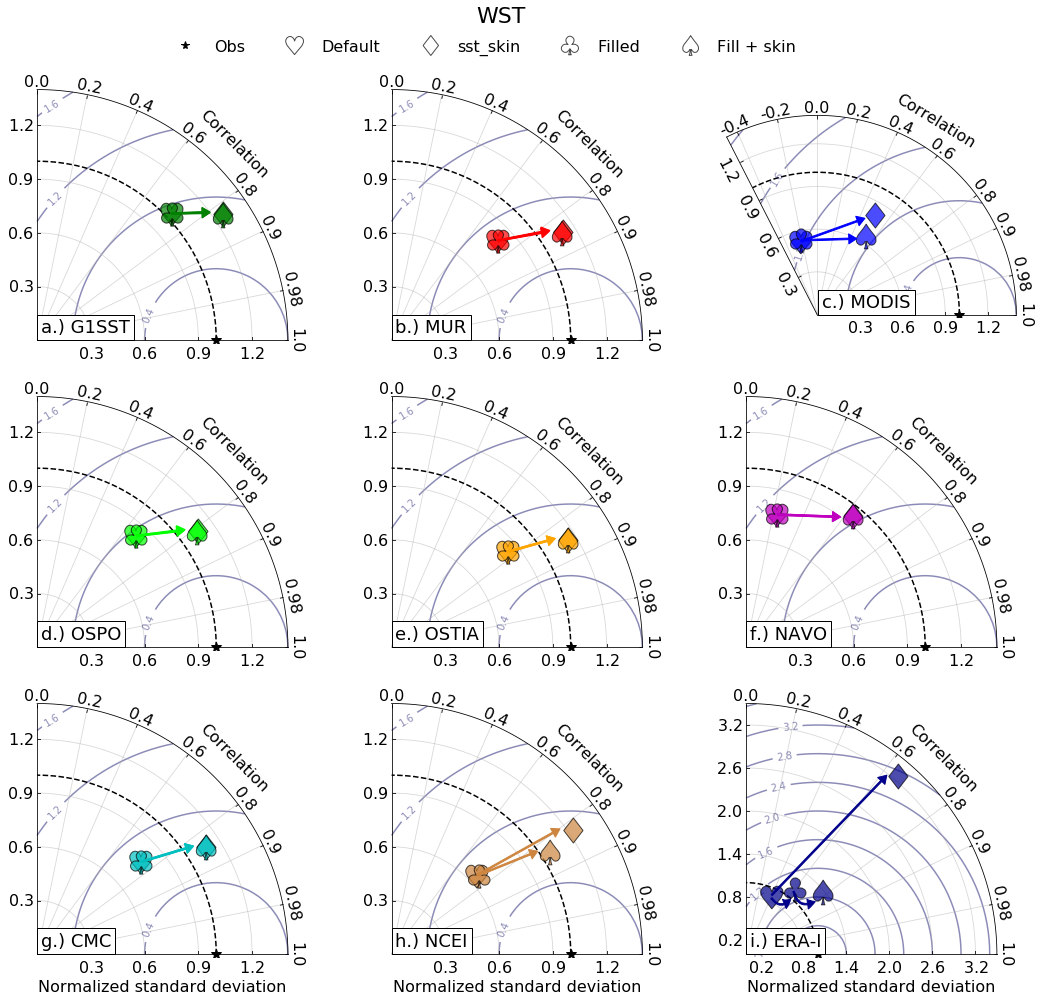

In [32]:
cases_of_interest = cases.copy()
doms_of_interest  = [3]*len(cases_of_interest)

stn_pair_dict = {}
for case in cases_of_interest:
    if 'NOFL_SKNT' in case:
        stn_pair_dict[case] = case.replace('SKNT','NOSK')
    if 'FILL_NOSK' in case:
        stn_pair_dict[case] = case.replace('FILL','NOFL')
    if 'FILL_SKNT' in case:
        stn_pair_dict[case] = case.replace('SKNT','NOSK')

plt_order = ['G1SST','MUR','MODIS','OSPO','OSTIA','NAVO','CMC','NCEI','DEFLT']
plt_order_full = []
for po in plt_order:
    for case in cases:
        if po in case:
            plt_order_full.append(case)
doms_of_interest  = [3]*len(plt_order_full)


var = 'sst'
fig = plt.figure(figsize=(18,16))
#plt.subplots_adjust(hspace=0.3)
#dia = TaylorDiagram(1.0, fig=fig, rect=122, extend=False,label='Obs',srange=[0.0,2.0])
#dia = TaylorDiagram(1.0, fig=fig, rect=224, extend=False,label='Obs',srange=[0.0,2.0])
if var != 'wdir':
    obs_var = var
    sim_var = vars_to_compare[var]
else:
    obs_var = '{}A'.format(var)
    sim_var = '{}A'.format(vars_to_compare[var])

extend = True


row = 0
col = 0
case_prev = 'DEFLT'
tdax = 331
td_stats = {}
sample_dict = {}
case_count = -1
for cc,case in enumerate(plt_order_full):
    case_plt_dict = case_dict[case]['d0{}'.format(doms_of_interest[cc])]
    td_stats[case] = pd.DataFrame(index=TD_stns, columns=['std_norm','R2'], dtype=float) 

    if (cc == 0) or (case.split('_')[0] != case_prev):
        case_count += 1
        if cc >= 31:
            TD_max_r = 3.5
            stdevticks = np.arange(0.2,5.6,0.6)
        else:
            TD_max_r = 1.4
            stdevticks = np.arange(0.3,5.6,0.3)
        if cc > 20:
            label_std = True
        else:
            label_std = False
        if 'MODIS' in case:
            extend = True
            extend_length = np.pi*0.65
            #TD_max_r = 1.2
            lbl_y = 0.025
            lbl_x = 0.333
        else:
            extend = False
            extend_length = np.pi*0.5
            lbl_y = 0.025
            lbl_x = 0.025
        dia = TaylorDiagram(1.0, fig=fig, 
                            extend=extend,
                            rect=tdax,
                            label='Obs',
                            normalize=True,
                            srange=[0.0,TD_max_r],
                            stdevticks=stdevticks,
                            labelsize=16,
                            corrticks=[0.0,0.2,0.4,0.6,0.8,0.9,0.98,1.0],
                            labelcoraxis=True,
                            labelstdaxis=label_std,
                            extend_length=extend_length)

        
        markers = ['$♥$','$♦$','$\\clubsuit$','$\\spadesuit$']
        leg_labels = ['Default','sst_skin','Filled','Fill + skin']
        for mm in range(0,4):
            sample_dict[case] = dia.add_sample(-1, 0,
                                            norm=False, # don't normalize this point
                                            marker=markers[mm], ms=25, ls='',
                                            mfc='none', mec='k', # Colors
                                            label=leg_labels[mm],
                                            zorder=cc+3,alpha=0.7)
        if case_count == 0:
            plt.legend(frameon=False,fontsize=16,
                       loc=(0.50,1.1),markerscale=0.8,
                       ncol=5)
            
        contours = dia.add_contours(levels=np.arange(0.4,4.6,0.4), colors='midnightblue',alpha=0.50,zorder=1)
        dia.ax.clabel(contours, inline=1, fontsize=10, fmt='%.1f')
        dia.add_grid(alpha=0.5)
        dia.ax.text(lbl_x,lbl_y,'{}.) {}'.format(ascii_lowercase[case_count],case_plt_dict['name']),size=18,
                    ha='left',va='bottom',bbox={'fc':'w'},
                    transform=dia.ax.transAxes,
                    zorder=1000)
        case_prev = case.split('_')[0]
        tdax += 1



    for ss,stn in enumerate(TD_stns):

        obs = TD_obs_full[stn][obs_var]
        obs = obs.dropna(how='any',dim='datetime')
        sim = TD_wrf_buoys[case][sim_var].sel(station=stn)
        sim = sim.dropna(how='any',dim='datetime')

        ref_std = np.std(obs.data)
        sim_std = np.std(sim.data)

        r2,_ = pearsonr(sim, obs)

        if ss == 0: 
            obs_full = obs - np.nanmean(obs)
            sim_full = sim - np.nanmean(sim)
            #label_str = '_'.join(case.replace('_KF','').split('_')[1:])
            label_str = None
        else:
            obs_full = np.concatenate([obs_full,obs - np.nanmean(obs)])
            sim_full = np.concatenate([sim_full,sim - np.nanmean(sim)])
            label_str = None
        #print(case,stn,np.std(sim.data)/ref_std)

        marker_c = stn_colors[stn]
        marker_e = stn_colors[stn]

        td_stats[case].loc[stn,'std_norm'] = sim_std/ref_std
        td_stats[case].loc[stn,'R2'] = r2

        dia.set_ref(ref_std)

        #dia.add_sample(np.std(sim.data), r2,
        #               marker=case_plt_dict['marker'], ms=8, ls='',
        #               mfc=marker_c, mec=marker_e, # Colors
        #               label=label_str,
        #               zorder=cc,alpha=0.15)

            #if cc == 0:
            #    txt_x = 0.38 + 0.17*stn_count
            #    txt_y = 0.12
                #plt.text(txt_x,txt_y,'{0}'.format(stn),c=stn_colors[stn],size=22,ha='center')
                #plt.text(txt_x,txt_y-0.08,'{0:2.1f}'.format(ref_std),size=18,ha='center')
                #if ss == 0: plt.text(txt_x-0.1,txt_y-0.08,'ref. STD: ',size=18,ha='right')


    td_stats[case]['angle'] = np.arccos(td_stats[case]['R2'])
    td_mean = td_stats[case].mean(axis=0)
    sample_dict[case] = dia.add_sample(td_mean['std_norm'], np.cos(td_mean['angle']),
                                    norm=False, # don't normalize this point
                                    marker=case_plt_dict['marker'], ms=25, ls='',
                                    mfc=case_plt_dict['color'], mec='k', # Colors
                                    label=case_plt_dict['name'],
                                    zorder=cc+3,alpha=0.7)

    
    if case in stn_pair_dict.keys():
        arrow_origin = sample_dict[stn_pair_dict[case]].get_xydata()
        arrow_end    = sample_dict[case].get_xydata()
        arrow_xs,arrow_ys = np.squeeze(arrow_origin)
        arrow_xe,arrow_ye = np.squeeze(arrow_end)
        arrow_dx,arrow_dy = np.squeeze(arrow_end) - np.squeeze(arrow_origin)
        arrow_len_weight = 0.7
        if case == 'DEFLT_FILL_SKNT':
            arrow_xe += -0.05
            arrow_ye += -0.1
            connection_style = 'arc3,rad=0.7'
        elif case == 'DEFLT_FILL_NOSK':
            arrow_xe += -0.05
            arrow_ye += -0.1
            connection_style = 'arc3,rad=0.7'
        else:
            arrow_xe += 0.03
            arrow_ye += -0.03
            connection_style = None
        arrow_len = (arrow_dx**2 + arrow_dy**2)**0.5
        if arrow_len >= 0.11:
            #print(arrow_len)
            arrow = patches.FancyArrowPatch((arrow_xs,arrow_ys),(arrow_xe,arrow_ye),connectionstyle=connection_style,
                                            color=case_dict[stn_pair_dict[case]]['d0{}'.format(doms_of_interest[cc])]['color'],
                                            arrowstyle='Simple, tail_width=1.5, head_width=10, head_length=8',zorder=100)
            dia.ax.add_patch(arrow)
plt.suptitle('WST',size=22,y=0.95)
figname = '{}WST_FullTD'.format(save_dir)
if save_figs:
    plt.savefig('{}.png'.format(figname), bbox_inches = 'tight',pad_inches = 0.1)
    plt.savefig('{}.pdf'.format(figname), bbox_inches = 'tight',pad_inches = 0.1)
    print(figname)
plt.show()

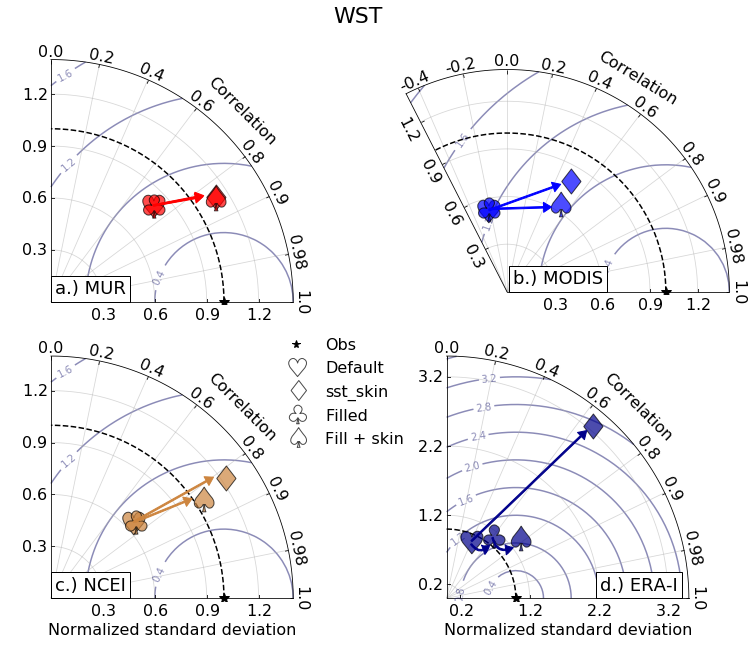

In [33]:
plt_order = ['MUR','MODIS','NCEI','DEFLT']
plt_order_full = []
for po in plt_order:
    for case in cases:
        if po in case:
            plt_order_full.append(case)
doms_of_interest  = [3]*len(plt_order_full)

var = 'sst'
fig = plt.figure(figsize=(13,10))
#plt.subplots_adjust(hspace=0.3)
#dia = TaylorDiagram(1.0, fig=fig, rect=122, extend=False,label='Obs',srange=[0.0,2.0])
#dia = TaylorDiagram(1.0, fig=fig, rect=224, extend=False,label='Obs',srange=[0.0,2.0])
if var != 'wdir':
    obs_var = var
    sim_var = vars_to_compare[var]
else:
    obs_var = '{}A'.format(var)
    sim_var = '{}A'.format(vars_to_compare[var])

extend = True

    


row = 0
col = 0
case_prev = 'DEFLT'
tdax = 221
td_stats = {}
sample_dict = {}
case_count = -1
for cc,case in enumerate(plt_order_full):
    case_plt_dict = case_dict[case]['d0{}'.format(doms_of_interest[cc])]
    td_stats[case] = pd.DataFrame(index=TD_stns, columns=['std_norm','R2'], dtype=float) 

    if (cc == 0) or (case.split('_')[0] != case_prev):
        case_count += 1
        if cc >= 11:
            TD_max_r = 3.5
            stdevticks = np.arange(0.2,5.6,1.0)
        else:
            TD_max_r = 2.0
            stdevticks = np.arange(0.3,5.6,0.3)

        label_std = False
        extend = False
        lbl_y = 0.027
        lbl_x = 0.027
        if 'MODIS' in case:
            lbl_x = 0.333
        elif 'DEFLT' in case:
            lbl_x = 0.63

        TD_max_r = 1.4
        extend_length = np.pi*0.5
        if 'DEFLT' in case:
            TD_max_r = 3.5
            label_std = True
        elif 'NCEI' in case:
            label_std = True
        elif 'MODIS' in case:
            extend_length = np.pi*0.65
            extend=True


        dia = TaylorDiagram(1.0, fig=fig, 
                            extend=extend,
                            rect=tdax,
                            label='Obs',
                            normalize=True,
                            srange=[0.0,TD_max_r],
                            stdevticks=stdevticks,
                            labelsize=16,
                            corrticks=[0.0,0.2,0.4,0.6,0.8,0.9,0.98,1.0],
                            labelcoraxis=True,
                            labelstdaxis=label_std,
                            extend_length=extend_length)

        contours = dia.add_contours(levels=np.arange(0.4,4.6,0.4), colors='midnightblue',alpha=0.50,zorder=1)
        dia.ax.clabel(contours, inline=1, fontsize=10, fmt='%.1f')
        dia.add_grid(alpha=0.5)
        dia.ax.text(lbl_x,lbl_y,'{}.) {}'.format(ascii_lowercase[case_count],case_plt_dict['name']),size=18,
                    ha='left',va='bottom',bbox={'fc':'w'},
                    transform=dia.ax.transAxes,
                    zorder=1000)
        case_prev = case.split('_')[0]
        tdax += 1



    for ss,stn in enumerate(TD_stns):

        obs = TD_obs_full[stn][obs_var]
        obs = obs.dropna(how='any',dim='datetime')
        sim = TD_wrf_buoys[case][sim_var].sel(station=stn)
        sim = sim.dropna(how='any',dim='datetime')

        ref_std = np.std(obs.data)
        sim_std = np.std(sim.data)

        r2,_ = pearsonr(sim, obs)

        if ss == 0: 
            obs_full = obs - np.nanmean(obs)
            sim_full = sim - np.nanmean(sim)
            #label_str = '_'.join(case.replace('_KF','').split('_')[1:])
            label_str = None
        else:
            obs_full = np.concatenate([obs_full,obs - np.nanmean(obs)])
            sim_full = np.concatenate([sim_full,sim - np.nanmean(sim)])
            label_str = None
        #print(case,stn,np.std(sim.data)/ref_std)

        marker_c = stn_colors[stn]
        marker_e = stn_colors[stn]

        td_stats[case].loc[stn,'std_norm'] = sim_std/ref_std
        td_stats[case].loc[stn,'R2'] = r2

        dia.set_ref(ref_std)

        #dia.add_sample(np.std(sim.data), r2,
        #               marker=case_plt_dict['marker'], ms=8, ls='',
        #               mfc=marker_c, mec=marker_e, # Colors
        #               label=label_str,
        #               zorder=cc,alpha=0.15)

            #if cc == 0:
            #    txt_x = 0.38 + 0.17*stn_count
            #    txt_y = 0.12
                #plt.text(txt_x,txt_y,'{0}'.format(stn),c=stn_colors[stn],size=22,ha='center')
                #plt.text(txt_x,txt_y-0.08,'{0:2.1f}'.format(ref_std),size=18,ha='center')
                #if ss == 0: plt.text(txt_x-0.1,txt_y-0.08,'ref. STD: ',size=18,ha='right')


    td_stats[case]['angle'] = np.arccos(td_stats[case]['R2'])
    td_mean = td_stats[case].mean(axis=0)
    sample_dict[case] = dia.add_sample(td_mean['std_norm'], np.cos(td_mean['angle']),
                                    norm=False, # don't normalize this point
                                    marker=case_plt_dict['marker'], ms=25, ls='',
                                    mfc=case_plt_dict['color'], mec='k', # Colors
                                    #label=case_plt_dict['name'],
                                    label=None,
                                    zorder=cc+3,alpha=0.7)
    

    if case in stn_pair_dict.keys():
        #print(case,stn_pair_dict[case])
        arrow_origin = sample_dict[stn_pair_dict[case]].get_xydata()
        arrow_end    = sample_dict[case].get_xydata()
        arrow_xs,arrow_ys = np.squeeze(arrow_origin)
        arrow_xe,arrow_ye = np.squeeze(arrow_end)
        arrow_dx,arrow_dy = np.squeeze(arrow_end) - np.squeeze(arrow_origin)
        arrow_len_weight = 0.6
        if case == 'DEFLT_FILL_SKNT':
            arrow_xe += -0.05
            arrow_ye += -0.1
            connection_style = 'arc3,rad=0.7'
        elif case == 'DEFLT_FILL_NOSK':
            arrow_xe += -0.05
            arrow_ye += -0.1
            connection_style = 'arc3,rad=0.7'
        elif case == 'DEFLT_NOFL_SKNT':
            arrow_xe += 0.0
            arrow_ye += -0.05
            connection_style = None
        else:
            arrow_xe += 0.03
            arrow_ye += -0.03
            connection_style = None
        arrow_len = (arrow_dx**2 + arrow_dy**2)**0.5
        if arrow_len >= 0.2:
            arrow = patches.FancyArrowPatch((arrow_xs,arrow_ys),(arrow_xe,arrow_ye),connectionstyle=connection_style,
                                            color=case_dict[stn_pair_dict[case]]['d0{}'.format(doms_of_interest[cc])]['color'],
                                            arrowstyle='Simple, tail_width=1.5, head_width=10, head_length=8',zorder=100)
            dia.ax.add_patch(arrow)
        
markers = ['$♥$','$♦$','$\\clubsuit$','$\\spadesuit$']
leg_labels = ['Default','sst_skin','Filled','Fill + skin']
for mm in range(0,4):
    sample_dict[case] = dia.add_sample(-1, 0,
                                    norm=False, # don't normalize this point
                                    marker=markers[mm], ms=25, ls='',
                                    mfc='none', mec='k', # Colors
                                    label=leg_labels[mm],
                                    zorder=cc+3,alpha=0.7)

plt.legend(frameon=False,fontsize=16,loc=(-0.69,0.6),markerscale=0.8)
plt.suptitle('WST',size=22,y=0.95)
figname = '{}WST_SKIN_SST_TD'.format(save_dir)
if save_figs:
    plt.savefig('{}.png'.format(figname), bbox_inches = 'tight',pad_inches = 0.1)
    plt.savefig('{}.pdf'.format(figname), bbox_inches = 'tight',pad_inches = 0.1)
    print(figname)
plt.show()

In [34]:
def resample_model_output_twr(stn_ds,twr_ds,var_dict,adjustments=None,select_stations=None):
    for vv,var in enumerate(var_dict):
        obs_var = var
        stn_var = var_dict[var]

        temp_ds = stn_ds.copy()
        temp_ds.drop_vars(stn_var)
        temp_var = stn_ds[stn_var].copy()
        if adjustments is not None and len(adjustments) == len(var_dict):
            adjustment = adjustments[vv]
            if adjustment is not None:
                print('Adjusting {} by {}'.format(var,adjustment))
                if adjustment[0] == '+' or adjustment[0] == '-':
                    temp_var += float(adjustment)
                elif adjustment[0] == '*':
                    temp_var = temp_var*float(adjustment[1:])
                elif adjustment[0] == '/':
                    temp_var = temp_var/float(adjustment[1:])
                else:
                    print('adjustment {} not understood. Please use +, -, *, or /'.format(adjustments))
        if select_stations is not None:
            station_list = select_stations
        else:
            station_list = stn_ds.station.data
        for ss,stn in enumerate(station_list):
            if type(twr_ds) == dict:
                obs = twr_ds[stn]
            elif type(twr_ds) == xr.core.dataset.Dataset:
                obs = twr_ds.sel(station=stn)
            else:
                'Need to figure out data type of twr_ds'
            var = temp_var.sel(station=stn,)
            
            var[np.where(np.isnan(obs[obs_var].data))] = var[np.where(np.isnan(obs[obs_var].data))]*np.nan

            temp_var.sel(station=stn).data = var.data

        stn_ds[stn_var] = temp_var
    return(stn_ds)

def KelvintoFahrenheit(T):
    return((9.0/5.0)*(T-273.0) + 32.0)

In [35]:
vars_to_compare_twr = {'temp':'t2'}

for ss,stn in enumerate(near_shore_stations):
    if stn in asos_ds.get_index('station'):
        twr_ds = asos_ds.sel(station=stn)
    elif stn in awos_ds.get_index('station'):
        twr_ds = awos_ds.sel(station=stn)
    #elif stn in apg_ds.get_index('station'):
    #    twr_ds = apg_ds.sel(station=stn)
    else:
        print('no obs for this station: {}'.format(stn))
    if stn == 'APG':
        twr_ds = apg_ds.sel(station='PAA')
        twr_ds.station.data = 'APG'
    twr_res = twr_ds.copy().sel(datetime=slice(t_s,t_e))
    for dd in twr_res.data_vars:
        if dd not in vars_to_compare_twr:
            twr_res = twr_res.drop_vars(dd)
    twr_res = twr_res.resample(datetime='1h').nearest(tolerance='1min')
    if ss == 0:
        twr_res_full = twr_res
    else:
        twr_res_full = xr.concat([twr_res_full,twr_res],dim='station')

wrf_twrs_res = {}
for cc,case in enumerate(wrf_twrs):        
    wrf_twrs_res[case] = resample_model_output_twr(wrf_twrs[case].copy().sel(datetime=slice(t_s,t_e)).resample(
                                                   datetime='1h').nearest(tolerance='1min'),
                                                   twr_res_full,var_dict=vars_to_compare_twr,
                                                   select_stations=near_shore_stations)

In [36]:
buoy_res = obs_res.copy()
closest_buoy_dict = {}
for twr in near_shore_stations:
    twr_lat = twr_res_full.sel(station=twr).lat.data
    twr_lon = twr_res_full.sel(station=twr).lon.data
    
    closest_buoy_dict[twr] = {}
    closest_buoy_dist = 999.9
    for buoy in (buoy_list):
        buoy_lat = buoy_res.sel(station=buoy).lat.data
        buoy_lon = buoy_res.sel(station=buoy).lon.data
        dist_from_buoy = np.sqrt((twr_lat - buoy_lat)**2 + (twr_lon - buoy_lon)**2)
        if dist_from_buoy < closest_buoy_dist:
            closest_buoy_dist = dist_from_buoy
            closest_buoy = buoy
    closest_buoy_dict[twr] = {'buoy':closest_buoy,
                              'dist':closest_buoy_dist}
    

In [37]:
sst_option = 'ind' # avg - average over buoys; ind - use closest

del_T = twr_res_full.temp.resample({'datetime':'1h'}).nearest()
del_T.name = 'delT'
del_TF = KelvintoFahrenheit(twr_res_full.temp.resample({'datetime':'1h'}).nearest())
del_TF.name = 'delT_F'

for ss,stn in enumerate(near_shore_stations):
    if sst_option == 'ind':
        closest_buoy = closest_buoy_dict[stn]['buoy']
        sst = buoy_res.sel(station=closest_buoy).sst
    elif sst_option == 'avg':
        sst = buoy_res.sel(station=shallow_buoys).sst.mean(dim='station')
    del_T.sel(station=stn).data -= sst
    del_TF.sel(station=stn).data -= KelvintoFahrenheit(sst)
    #twr_res_full['delT'] = del_T
    #twr_res_full['delT_F'] = del_TF
    
delT_mean = twr_res_full.temp.sel(station=near_shore_stations).resample({'datetime':'1h'}).nearest().mean(dim='station') - \
            buoy_res.sel(station=shallow_buoys).sst.mean(dim='station')
delTF_mean = KelvintoFahrenheit(twr_res_full.temp.sel(station=near_shore_stations).resample({'datetime':'1h'}).nearest().mean(dim='station')) - \
            KelvintoFahrenheit(buoy_res.sel(station=shallow_buoys).sst.mean(dim='station'))

twr_res_full['delT'] = del_T
twr_res_full['delT_mean'] = delT_mean
twr_res_full['delT_F'] = del_TF
twr_res_full['delT_F_mean'] = delTF_mean

In [38]:
missing_option = 'skin' # skin or first

for cc,case in enumerate(wrf_twrs):        
    
    del_T = wrf_twrs_res[case].t2+273.15
    del_T.name = 'delT'
    del_TF = KelvintoFahrenheit(wrf_twrs_res[case].t2+273.15)
    del_TF.name = 'delT_F'
    

    sst_name = 'sst'
    for ss,stn in enumerate(near_shore_stations):
        if sst_option == 'ind':
            closest_buoy = closest_buoy_dict[stn]['buoy']
            sst = wrf_buoys_res[case].sel(station=closest_buoy)[sst_name]
        elif sst_option == 'avg':
            sst = wrf_buoys_res[case].sel(station=shallow_buoys)[sst_name]
            sst = sst.where(sst>0).mean(dim='station')

        sst_fill = sst.where(sst > 0.0).dropna(how='any',dim='datetime')
        if len(sst_fill) == 0:
            if missing_option == 'skin':
                sst = wrf_buoys_res[case].sel(station=closest_buoy).tsk + 273.15
            else:
                sst += wrf_buoys_res[case].sel(station=closest_buoy).tsk[0] + 273.15

        del_T.sel(station=stn).data -= sst
        #del_T.sel(station=stn).plot()
        del_TF.sel(station=stn).data -= KelvintoFahrenheit(sst)
    #plt.show()
    
    t2_mean = wrf_twrs_res[case].t2.sel(station=near_shore_stations).mean(dim='station')+273.15
    sst_mean = wrf_buoys_res[case][sst_name].sel(station=shallow_buoys).copy()

    sst_mean_fill = sst_mean.where(sst_mean > 0.0).mean(dim='station')
    if len(sst_mean_fill.dropna(how='any',dim='datetime')) == 0:
        if missing_option == 'skin':
            sst_mean = wrf_buoys_res[case].tsk.sel(station=shallow_buoys).mean(dim='station') + 273.15
        else:
            sst_mean = sst_mean.mean(dim='station') + \
                       wrf_buoys_res[case].tsk.sel(station=shallow_buoys).mean(dim='station')[0] + 273.15
    else:
        sst_mean = sst_mean.where(sst_mean > 0.0).mean(dim='station')

    delT_mean = t2_mean - sst_mean
    delT_mean.name = 'delT_mean'
    delTF_mean = KelvintoFahrenheit(t2_mean) - KelvintoFahrenheit(sst_mean)
    delTF_mean.name = 'delT_F_mean'

    wrf_twrs_res[case]['delT'] = del_T
    wrf_twrs_res[case]['delT_mean'] = delT_mean
    wrf_twrs_res[case]['delT_F'] = del_TF
    wrf_twrs_res[case]['delT_F_mean'] = delTF_mean

/glade/u/home/hawbecke/local/envs/mmc/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [39]:
#sst_obs = buoy_res.sst.sel(station=shallow_buoys).mean(dim='station')
#t2_obs = twr_res_full.temp.sel(station=near_shore_stations).mean(dim='station')
#tdiff_obs = t2_obs - sst_obs
#tdiff_obs.name = 'dT'

mean_type = 'ind' # ind or avg

if mean_type == 'ind':
    tdiff_obs = twr_res_full['delT'].sel(station=near_shore_stations).mean(dim='station')
else:
    tdiff_obs = twr_res_full['delT_mean']
tdiff_obs.name = 'dT'

tdiff_wrf = {}
for cc,case in enumerate(wrf_twrs):
    if mean_type == 'ind':
        tdiff_avg = wrf_twrs_res[case]['delT'].sel(station=near_shore_stations).mean(dim='station')
    else:
        tdiff_avg = wrf_twrs_res[case]['delT_mean']
    tdiff_avg.name = 'dT'    
    tdiff_wrf[case] = tdiff_avg


#for cc,case in enumerate(wrf_twrs):        
#    tdiff_wrf[case].plot()
#    tdiff_obs.plot(c='k',ls=':')
#    plt.show()

/glade/work/hawbecke/ATEC/Chesapeake/SENSITIVITY_STUDY/20190716to20190801/img/DeltaT_TD


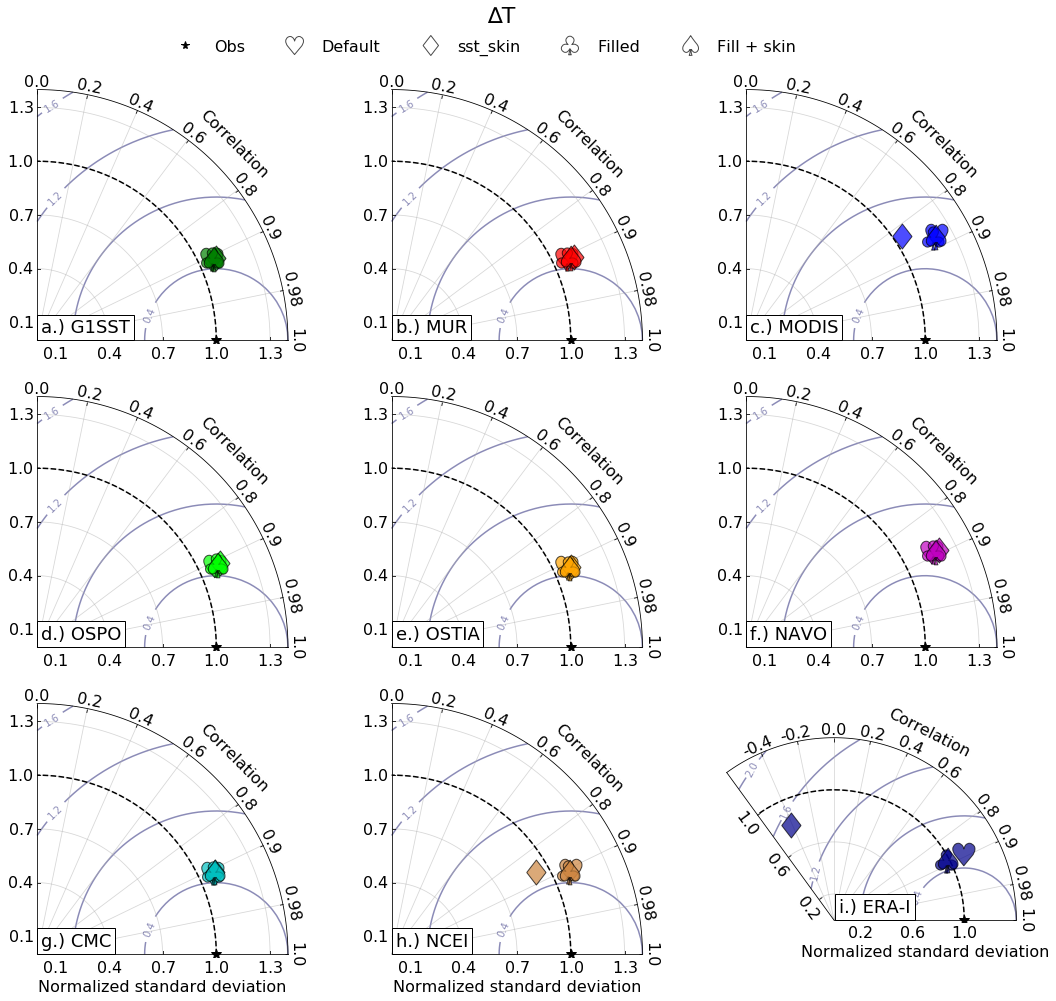

In [40]:
plt_order = ['G1SST','MUR','MODIS','OSPO','OSTIA','NAVO','CMC','NCEI','DEFLT']
plt_order_full = []
for po in plt_order:
    for case in cases:
        if po in case:
            plt_order_full.append(case)
doms_of_interest  = [3]*len(plt_order_full)

var = 'dT'
fig = plt.figure(figsize=(18,16))

extend = False
show_arrows = False

row = 0
col = 0
case_prev = 'DEFLT'
tdax = 331
td_stats = {}
sample_dict = {}
case_count = -1

for cc,case in enumerate(plt_order_full):
    case_plt_dict = case_dict[case]['d0{}'.format(doms_of_interest[cc])]
    td_stats[case] = pd.DataFrame(index=TD_stns, columns=['std_norm','R2'], dtype=float) 

    if (cc == 0) or (case.split('_')[0] != case_prev):
        case_count += 1

        TD_max_r = 1.4
        stdevticks = np.arange(0.1,5.6,0.3)
        if cc > 20:
            label_std = True
        else:
            label_std = False
        if 'DEFLT' in case:
            extend = True
            extend_length = np.pi*0.7
            stdevticks = np.arange(0.2,5.6,0.4)
            #TD_max_r = 1.2
            lbl_y = 0.033
            lbl_x = 0.39
        else:
            extend = False
            extend_length = np.pi*0.5
            lbl_y = 0.025
            lbl_x = 0.025
        dia = TaylorDiagram(1.0, fig=fig, 
                            extend=extend,
                            rect=tdax,
                            label='Obs',
                            normalize=True,
                            srange=[0.0,TD_max_r],
                            stdevticks=stdevticks,
                            labelsize=16,
                            corrticks=[0.0,0.2,0.4,0.6,0.8,0.9,0.98,1.0],
                            labelcoraxis=True,
                            labelstdaxis=label_std,
                            extend_length=extend_length)

        markers = ['$♥$','$♦$','$\\clubsuit$','$\\spadesuit$']
        leg_labels = ['Default','sst_skin','Filled','Fill + skin']
        for mm in range(0,4):
            sample_dict[case] = dia.add_sample(-1, 0,
                                            norm=False, # don't normalize this point
                                            marker=markers[mm], ms=25, ls='',
                                            mfc='none', mec='k', # Colors
                                            label=leg_labels[mm],
                                            zorder=cc+3,alpha=0.7)
        if case_count == 0:
            plt.legend(frameon=False,fontsize=16,
                       loc=(0.50,1.1),markerscale=0.8,
                       ncol=5)

        
        contours = dia.add_contours(levels=np.arange(0.4,4.6,0.4), colors='midnightblue',alpha=0.50,zorder=1)
        dia.ax.clabel(contours, inline=1, fontsize=10, fmt='%.1f')
        dia.add_grid(alpha=0.5)
        dia.ax.text(lbl_x,lbl_y,'{}.) {}'.format(ascii_lowercase[case_count],case_plt_dict['name']),size=18,
                    ha='left',va='bottom',bbox={'fc':'w'},
                    transform=dia.ax.transAxes,
                    zorder=1000)
        case_prev = case.split('_')[0]
        tdax += 1


    td_stats[case]['angle'] = np.arccos(td_stats[case]['R2'])
    td_mean = td_stats[case].mean(axis=0)
    
    obs = tdiff_obs
    sim = tdiff_wrf[case]
    sim = sim.where(~np.isnan(obs))
    obs = obs.dropna(how='any',dim='datetime')
    sim = sim.dropna(how='any',dim='datetime')

    ref_std = np.std(obs.data)
    sim_std = np.std(sim.data)
    r2,_ = pearsonr(sim, obs)
    dia.set_ref(ref_std)

    sample_dict[case] =  dia.add_sample(np.std(sim.data), r2,
                                       marker=case_plt_dict['marker'], ms=25, ls='',
                                       mfc=case_plt_dict['color'], mec='k', # Colors
                                       label=None,
                                       zorder=cc+3,alpha=0.7)

    if show_arrows:
        if case in stn_pair_dict.keys():
            print(case,stn_pair_dict[case])
            arrow_origin = sample_dict[stn_pair_dict[case]].get_xydata()
            arrow_end    = sample_dict[case].get_xydata()
            arrow_xs,arrow_ys = np.squeeze(arrow_origin)
            arrow_xe,arrow_ye = np.squeeze(arrow_end)
            arrow_dx,arrow_dy = np.squeeze(arrow_end) - np.squeeze(arrow_origin)
            arrow_len_weight = 0.7
            if case == 'DEFLT_FILL_SKNT':
                arrow_xe += -0.05
                arrow_ye += -0.1
                connection_style = 'arc3,rad=0.7'
            elif case == 'DEFLT_FILL_NOSK':
                arrow_xe += -0.05
                arrow_ye += -0.1
                connection_style = 'arc3,rad=0.7'
            else:
                arrow_xe += 0.03
                arrow_ye += -0.03
                connection_style = None
            arrow_len = (arrow_dx**2 + arrow_dy**2)**0.5
            if arrow_len >= 0.11:
                #print(arrow_len)
                arrow = patches.FancyArrowPatch((arrow_xs,arrow_ys),(arrow_xe,arrow_ye),connectionstyle=connection_style,
                                                color=case_dict[stn_pair_dict[case]]['d0{}'.format(doms_of_interest[cc])]['color'],
                                                arrowstyle='Simple, tail_width=1.5, head_width=10, head_length=8',zorder=100)
                dia.ax.add_patch(arrow)
                
plt.suptitle('∆T',size=22,y=0.95)
figname = '{}DeltaT_TD'.format(save_dir)
save_figs = True
if save_figs:
    plt.savefig('{}.png'.format(figname), bbox_inches = 'tight',pad_inches = 0.1)
    plt.savefig('{}.pdf'.format(figname), bbox_inches = 'tight',pad_inches = 0.1)
    print(figname)
plt.show()

# Not much difference in ∆T Plots due to influence of T2 > influence of SST:

In [41]:
from matplotlib.legend_handler import HandlerBase


class AnyObjectHandler(HandlerBase):
    def create_artists(self, legend, orig_handle,
                       x0, y0, width, height, fontsize, trans):
        l1 = plt.Line2D([x0,y0+width], [0.8*height,0.8*height],
                           color=orig_handle[0],lw=3.0)
        l2 = plt.Line2D([x0,y0+width], [0.2*height,0.2*height], 
                           color=orig_handle[1],lw=3.0)
        return [l1, l2]

/glade/work/hawbecke/ATEC/Chesapeake/SENSITIVITY_STUDY/20190716to20190801/img/T2_WST_Comparison


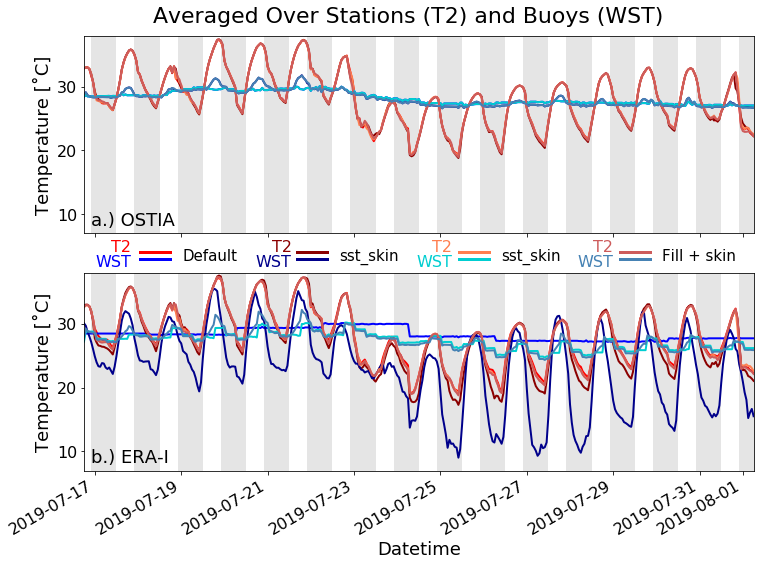

In [43]:
var = 'dT'
fig,ax = plt.subplots(nrows=2,ncols=1,figsize=(12,8),sharex=True,sharey=True)

example_cases = ['OSTIA','DEFLT']
legend_handles = []
legend_labels = []

plt_color_dict = {'NOFL_NOSK':{
                             't2':'r',
                            'sst':'b',
                            'lbl':'Default',
                              },
                  'NOFL_SKNT':{
                             't2':'darkred',
                            'sst':'darkblue',
                            'lbl':'sst_skin',
                              },
                  'FILL_NOSK':{
                             't2':'coral',
                            'sst':'darkturquoise',
                            'lbl':'sst_skin',
                              },
                  'FILL_SKNT':{
                             't2':'indianred',
                            'sst':'steelblue',
                            'lbl':'Fill + skin',
                             },
                  }
lbl_count = 0
for cc,case in enumerate(cases):
    if example_cases[0] in case:
        row = 0
        lbl_leg = True
        lbl_count += 1
    elif example_cases[1] in case:
        row = 1
        lbl_leg = False
    else:
        row = -999
        
    if row >= 0:
        case_plt_dict = case_dict[case]['d0{}'.format(doms_of_interest[cc])]

        wrf_t2 = wrf_twrs_res[case].t2.sel(station=near_shore_stations).mean(dim='station')
        wrf_sst = wrf_buoys_res[case].tsk.sel(station=shallow_buoys).mean(dim='station') #- 273.15
        
        if 'NOFL_NOSK' in case:
            case_str = 'NOFL_NOSK'
        elif 'NOFL_SKNT' in case:
            case_str = 'NOFL_SKNT'
        elif 'FILL_NOSK' in case:
            case_str = 'FILL_NOSK'
        elif 'FILL_SKNT' in case:
            case_str = 'FILL_SKNT'
        color_dict = plt_color_dict[case_str]
        t2c = color_dict['t2']
        sstc = color_dict['sst']
        lbl = color_dict['lbl']
        lw = 2.0
        sst_lbl = lbl
        t2_lbl = lbl           
        t2_plt = wrf_t2.plot(c=t2c,ax=ax[row],label=t2_lbl,lw=lw)
        sst_plt = wrf_sst.plot(c=sstc,ax=ax[row],label=sst_lbl,lw=lw)
        legend_x = 0.07
        if lbl_leg:
            txt_x = legend_x + 0.24*(lbl_count-1)
            ax[1].text(txt_x,1.09,'T2',transform=ax[1].transAxes,ha='right',va='bottom',size=16,c=t2c)
            ax[1].text(txt_x,1.09,'WST',transform=ax[1].transAxes,ha='right',va='top',size=16,c=sstc)

        
        if row == 0:
            legend_handles.append((t2c,sstc))
            legend_labels.append(lbl)
ax[1].legend(legend_handles, legend_labels,fontsize=15,
             handler_map={tuple: AnyObjectHandler()},
             frameon=False,ncol=4,loc=(legend_x + 0.005,1.01),
             columnspacing=4.0)


for axi in range(0,2):
    plt_start_date = pd.to_datetime(obs.datetime.values[0])
    plt_end_date = pd.to_datetime(obs.datetime.values[-1])
    for day in pd.date_range(start=plt_start_date - pd.to_timedelta(1,'d'), end=plt_end_date):
        night_s = pd.to_datetime('{0:04d}-{1:02d}-{2:02d} {3:02d}:00'.format(day.year,day.month,day.day,night_hour_s))
        night_e = pd.to_datetime('{0:04d}-{1:02d}-{2:02d} {3:02d}:00'.format(day.year,day.month,day.day,night_hour_e)) + pd.Timedelta(1,'d')
        ax[axi].fill_betweenx([-100,400],night_s,night_e,facecolor='k',alpha=0.1)   

ax[0].set_ylim(7,38)
ax[0].set_xlabel(None)
ax[0].set_xlim(wrf_t2.datetime.data[0],wrf_t2.datetime.data[-1])
ax[1].set_xlabel('Datetime',size=18)
#ax[0].legend(frameon=False,fontsize=15,ncol=4,loc=(0.0,1.01))
#ax[1].legend(frameon=False,fontsize=15,ncol=4,loc=(0.0,1.01))
for row in [0,1]:
    ax[row].tick_params(labelsize=16)
    ax[row].text(0.01,0.04,'{}.) {}'.format(ascii_lowercase[row],case_dict[example_cases[row]+'_NOFL_NOSK']['d0{}'.format(doms_of_interest[cc])]['name']),
                 size=18,transform=ax[row].transAxes)
    ax[row].set_ylabel('Temperature [˚C]',size=18)

plt.suptitle('Averaged Over Stations (T2) and Buoys (WST)',size=22,y=0.93)
#    ax[row].plot(sst_obs.datetime,sst_obs,c='darkblue')
#    ax[row].plot(t2_obs.datetime,t2_obs,c='darkred')
figname = '{}T2_WST_Comparison'.format(save_dir)
save_figs = True
if save_figs:
    plt.savefig('{}.png'.format(figname), bbox_inches = 'tight',pad_inches = 0.1)
    plt.savefig('{}.pdf'.format(figname), bbox_inches = 'tight',pad_inches = 0.1)
    print(figname)
plt.show()



In [31]:
cases_of_interest = []
for case in cases:
    if 'NOFL_SKNT' in case:
        cases_of_interest.append(case)
doms_of_interest  = [3]*len(cases_of_interest)

stns_for_plot = ['YKP','TBL']
var = 'sst'
var_str = 'WST [˚C]'

if var != 'wdir':
    obs_var = var
    sim_var = vars_to_compare[var]
else:
    obs_var = '{}A'.format(var)
    sim_var = '{}A'.format(vars_to_compare[var])

fig,ax = plt.subplots(len(stns_for_plot),sharex=True,figsize=(9,7))
for ss,stn in enumerate(stns_for_plot):

    obs = TD_obs_full_sub[stn][obs_var]


    ref_std = np.std(obs.dropna(how='any',dim='datetime').data)

    for cc,case in enumerate(cases_of_interest):
        case_plt_dict = case_dict[case]['d0{}'.format(doms_of_interest[cc])]
        sim = TD_wrf_buoys_sub[case][sim_var].sel(station=stn)

        if cc == 0:
            obs_plt = obs#.dropna(how='any',dim='datetime')
            if len(obs.dropna(how='any',dim='datetime')) > 2:
                obs_plt.plot(ax=ax[ss],c='k',marker='o')
        if len(sim.dropna(how='any',dim='datetime')) > 2:
            sim_plt = sim#.dropna(how='any',dim='datetime')
            sim_plt.plot(ax=ax[ss],label='{}'.format(case_plt_dict['name'].split('_')[0]),
                         c=case_plt_dict['color'],
                         #ls=case_plt_dict['ls'])
                         ls='-')

    ax[ss].set_ylabel(sim_var,size=16)
    if ss == len(TD_stns) - 1:
        ax[ss].set_xlabel('Datetime',size=16)
    else:
        ax[ss].set_xlabel('')
    if ss == 0:
        ax[ss].set_title(var,size=18)
    else:
        ax[ss].set_title('')

    if var == 'wspd':
        ymin,ymax = 0,15
    if var == 'wdir':
        ymin,ymax = 0,0.5
    if var == 'sst':
        ymin,ymax = 2,38
    if var == 'temp':
        ymin,ymax = 15,40
    if var == 'u':
        ymin,ymax = -10,10
    if var == 'v':
        ymin,ymax = -10,10
    if var == 'pres':
        ymin,ymax = 1005,1030

    ax[ss].set_yticks(np.arange(5,46,10))
    ax[ss].set_ylim(ymin,ymax)
    ax[ss].tick_params(labelsize=16)
    if ss == 2:
        ax[ss].set_ylabel(var_str_dict[var],size=16)
    else:
        ax[ss].set_ylabel('')

    ax[ss].set_xlim(sim.datetime.data[0],sim.datetime.data[-1])
#    ax[ss].text(obs.datetime.data[5],ymax + 0.01*(ymax-ymin),stn,va='bottom',ha='left',size=16)
    txt_y = ymin + 0.02*(ymax-ymin)
    if stn == 'DEB': txt_y = ymin + 0.82*(ymax-ymin)
    ax[ss].text(obs.datetime.data[3],txt_y,'{}.) {}'.format(ascii_lowercase[ss],stn),va='bottom',ha='left',size=16)
    plt_start_date = pd.to_datetime(obs.datetime.values[0])
    plt_end_date = pd.to_datetime(obs.datetime.values[-1])
    for day in pd.date_range(start=plt_start_date - pd.to_timedelta(1,'d'), end=plt_end_date):
        night_s = pd.to_datetime('{0:04d}-{1:02d}-{2:02d} {3:02d}:00'.format(day.year,day.month,day.day,night_hour_s))
        night_e = pd.to_datetime('{0:04d}-{1:02d}-{2:02d} {3:02d}:00'.format(day.year,day.month,day.day,night_hour_e)) + pd.Timedelta(1,'d')
        ax[ss].fill_betweenx([-100,400],night_s,night_e,facecolor='k',alpha=0.1)   
ax[0].legend(frameon=False,ncol=5,loc=(-0.01,1.01),fontsize=14,handlelength=1.75)
ax[0].set_title('')
ax[-1].set_xlabel('Datetime',size=16)
plt.suptitle('SST_SKIN = 1',size=20,y=1.02)
figname = '{}NOFLSKNT_WST_timeseries'.format(save_dir)
if save_figs:
    plt.savefig('{}.png'.format(figname), bbox_inches = 'tight',pad_inches = 0.1)
    plt.savefig('{}.pdf'.format(figname), bbox_inches = 'tight',pad_inches = 0.1)
    print(figname)
plt.show()


In [38]:
cases_of_interest = []
for case in cases:
    if 'FILL_SKNT' in case:
        cases_of_interest.append(case)
doms_of_interest  = [3]*len(cases_of_interest)

stns_for_plot = ['YKP','TBL']
var = 'sst'
var_str = 'WST [˚C]'

if var != 'wdir':
    obs_var = var
    sim_var = vars_to_compare[var]
else:
    obs_var = '{}A'.format(var)
    sim_var = '{}A'.format(vars_to_compare[var])

fig,ax = plt.subplots(len(stns_for_plot),sharex=True,figsize=(9,7))
for ss,stn in enumerate(stns_for_plot):

    obs = TD_obs_full_sub[stn][obs_var]


    ref_std = np.std(obs.dropna(how='any',dim='datetime').data)

    for cc,case in enumerate(cases_of_interest):
        case_plt_dict = case_dict[case]['d0{}'.format(doms_of_interest[cc])]
        sim = TD_wrf_buoys_sub[case][sim_var].sel(station=stn)

        if cc == 0:
            obs_plt = obs#.dropna(how='any',dim='datetime')
            if len(obs.dropna(how='any',dim='datetime')) > 2:
                obs_plt.plot(ax=ax[ss],c='k',marker='o')
        if len(sim.dropna(how='any',dim='datetime')) > 2:
            sim_plt = sim#.dropna(how='any',dim='datetime')
            sim_plt.plot(ax=ax[ss],label='{}'.format(case_plt_dict['name'].split('_')[0]),
                         c=case_plt_dict['color'],
                         #ls=case_plt_dict['ls'])
                         ls='-')

    ax[ss].set_ylabel(sim_var,size=16)
    if ss == len(TD_stns) - 1:
        ax[ss].set_xlabel('Datetime',size=16)
    else:
        ax[ss].set_xlabel('')
    if ss == 0:
        ax[ss].set_title(var,size=18)
    else:
        ax[ss].set_title('')

    if var == 'wspd':
        ymin,ymax = 0,15
    if var == 'wdir':
        ymin,ymax = 0,0.5
    if var == 'sst':
        ymin,ymax = 23,34
    if var == 'temp':
        ymin,ymax = 15,40
    if var == 'u':
        ymin,ymax = -10,10
    if var == 'v':
        ymin,ymax = -10,10
    if var == 'pres':
        ymin,ymax = 1005,1030

    ax[ss].set_yticks(np.arange(6,46,3))
    ax[ss].set_ylim(ymin,ymax)
    ax[ss].tick_params(labelsize=16)
    if ss == 2:
        ax[ss].set_ylabel(var_str_dict[var],size=16)
    else:
        ax[ss].set_ylabel('')

    ax[ss].set_xlim(sim.datetime.data[0],sim.datetime.data[-1])
#    ax[ss].text(obs.datetime.data[5],ymax + 0.01*(ymax-ymin),stn,va='bottom',ha='left',size=16)
    txt_y = ymin + 0.02*(ymax-ymin)
    if stn == 'DEB': txt_y = ymin + 0.82*(ymax-ymin)
    ax[ss].text(obs.datetime.data[3],txt_y,'{}.) {}'.format(ascii_lowercase[ss],stn),va='bottom',ha='left',size=16)
    plt_start_date = pd.to_datetime(obs.datetime.values[0])
    plt_end_date = pd.to_datetime(obs.datetime.values[-1])
    for day in pd.date_range(start=plt_start_date - pd.to_timedelta(1,'d'), end=plt_end_date):
        night_s = pd.to_datetime('{0:04d}-{1:02d}-{2:02d} {3:02d}:00'.format(day.year,day.month,day.day,night_hour_s))
        night_e = pd.to_datetime('{0:04d}-{1:02d}-{2:02d} {3:02d}:00'.format(day.year,day.month,day.day,night_hour_e)) + pd.Timedelta(1,'d')
        ax[ss].fill_betweenx([-100,400],night_s,night_e,facecolor='k',alpha=0.1)   
ax[0].legend(frameon=False,ncol=5,loc=(-0.01,1.01),fontsize=14,handlelength=1.75)
ax[0].set_title('')
ax[-1].set_xlabel('Datetime',size=16)
plt.suptitle('Fill missing and SST_SKIN = 1',size=20,y=1.02)
figname = '{}FILLSKNT_WST_timeseries'.format(save_dir)
if save_figs:
    plt.savefig('{}.png'.format(figname), bbox_inches = 'tight',pad_inches = 0.1)
    plt.savefig('{}.pdf'.format(figname), bbox_inches = 'tight',pad_inches = 0.1)
    print(figname)
plt.show()


DEFLT_NOFL_SKNT DEFLT_NOFL_NOSK 2.0277956662746415
G1SST_NOFL_SKNT G1SST_NOFL_NOSK 0.3968715367824073
MUR1K_NOFL_SKNT MUR1K_NOFL_NOSK 0.3737660882145458
MODIS_NOFL_SKNT MODIS_NOFL_NOSK 0.7698958315530448
OSPOG_NOFL_SKNT OSPOG_NOFL_NOSK 0.35147173608014315
OSTIA_NOFL_SKNT OSTIA_NOFL_NOSK 0.3417871251133918
NAVOK_NOFL_SKNT NAVOK_NOFL_NOSK 0.46991936555189023
CMC01_NOFL_SKNT CMC01_NOFL_NOSK 0.36932398329502975
NCEIA_NOFL_SKNT NCEIA_NOFL_NOSK 0.9940054761956855


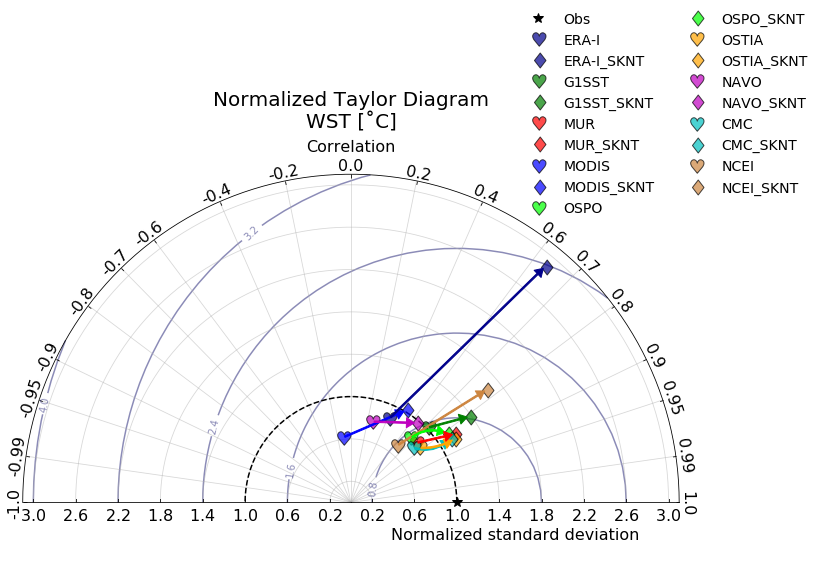

In [36]:
var = 'sst'
fig = plt.figure(figsize=(12,8))
#dia = TaylorDiagram(1.0, fig=fig, rect=122, extend=False,label='Obs',srange=[0.0,2.0])
#dia = TaylorDiagram(1.0, fig=fig, rect=224, extend=False,label='Obs',srange=[0.0,2.0])
if var != 'wdir':
    obs_var = var
    sim_var = vars_to_compare[var]
else:
    obs_var = '{}A'.format(var)
    sim_var = '{}A'.format(vars_to_compare[var])

extend = False
if var == 'pres':
    TD_max_r = 1.3
elif var == 'temp':
    TD_max_r = 1.5
elif var == 'wspd':
    TD_max_r = 1.5
elif var == 'sst':
    TD_max_r = 3.1
    extend = True
else:
    TD_max_r = 1.5
    
dia = TaylorDiagram(1.0, fig=fig, 
                    extend=extend,
                    #rect=122,
                    label='Obs',
                    normalize=True,
                    srange=[0.0,TD_max_r],
                    stdevticks=np.arange(0.2,5.6,0.4),
                    labelsize=16)
td_stats = {}

sample_dict = {}
for cc,case in enumerate(cases_of_interest):
    case_plt_dict = case_dict[case]['d0{}'.format(doms_of_interest[cc])]
    td_stats[case] = pd.DataFrame(index=TD_stns, columns=['std_norm','R2'], dtype=float) 

    for ss,stn in enumerate(TD_stns):

        obs = TD_obs_full[stn][obs_var]
        obs = obs.dropna(how='any',dim='datetime')
        sim = TD_wrf_buoys[case][sim_var].sel(station=stn)
        sim = sim.dropna(how='any',dim='datetime')

        ref_std = np.std(obs.data)
        sim_std = np.std(sim.data)

        r2,_ = pearsonr(sim, obs)

        if ss == 0: 
            obs_full = obs - np.nanmean(obs)
            sim_full = sim - np.nanmean(sim)
            #label_str = '_'.join(case.replace('_KF','').split('_')[1:])
            label_str = None
        else:
            obs_full = np.concatenate([obs_full,obs - np.nanmean(obs)])
            sim_full = np.concatenate([sim_full,sim - np.nanmean(sim)])
            label_str = None
        #print(case,stn,np.std(sim.data)/ref_std)

        marker_c = stn_colors[stn]
        marker_e = stn_colors[stn]

        td_stats[case].loc[stn,'std_norm'] = sim_std/ref_std
        td_stats[case].loc[stn,'R2'] = r2

        #dia.set_ref(ref_std)

        #dia.add_sample(np.std(sim.data), r2,
        #               marker=case_plt_dict['marker'], ms=8, ls='',
        #               mfc=marker_c, mec=marker_e, # Colors
        #               label=label_str,
        #               zorder=cc,alpha=0.2)


    multimodal_mean = False

    if multimodal_mean:
        ref_std_full = np.std(obs_full)

        dia.add_sample(np.std(sim_full)/ref_std_full, np.corrcoef(sim_full,obs_full)[0,1],
               marker=case_plt_dict['marker'], ms=15, ls='',
               mfc=case_plt_dict['color'], mec='k', # Colors
               label=case_plt_dict['name'],
               zorder=cc+3,alpha=0.7)
    else:        
        td_stats[case]['angle'] = np.arccos(td_stats[case]['R2'])
        td_mean = td_stats[case].mean(axis=0)
        sample_dict[case] = dia.add_sample(td_mean['std_norm'], np.cos(td_mean['angle']),
                                        norm=False, # don't normalize this point
                                        marker=case_plt_dict['marker'], ms=15, ls='',
                                        mfc=case_plt_dict['color'], mec='k', # Colors
                                        label=case_plt_dict['name'],
                                        zorder=cc+3,alpha=0.7)

for cc,case in enumerate(cases_of_interest):
    if case in stn_pair_dict.keys():
        arrow_origin = sample_dict[stn_pair_dict[case]].get_xydata()
        arrow_end    = sample_dict[case].get_xydata()
        arrow_xs,arrow_ys = np.squeeze(arrow_origin)
        arrow_xe,arrow_ye = np.squeeze(arrow_end)
        arrow_dx,arrow_dy = np.squeeze(arrow_end) - np.squeeze(arrow_origin)
        arrow_len = (arrow_dx**2 + arrow_dy**2)**0.5
        arrow_len_weight = 0.7
        print(case,stn_pair_dict[case],arrow_len)
        if 'OSPOG' in case:
            connection_style = 'arc3,rad=-.3'
        elif 'CMC01' in case:
            connection_style = 'arc3,rad=.3'
        elif 'OSTIA' in case:
            connection_style = 'arc3,rad=.15'
        else:
            connection_style = None

        arrow = patches.FancyArrowPatch((arrow_xs,arrow_ys),(arrow_xe,arrow_ye),connectionstyle=connection_style,
                                        color=case_dict[stn_pair_dict[case]]['d0{}'.format(doms_of_interest[cc])]['color'],
                                        arrowstyle='Simple, tail_width=1.5, head_width=10, head_length=8',zorder=100)
        dia.ax.add_patch(arrow)
        #dia.ax.arrow(arrow_x,arrow_y,arrow_dx*arrow_len_weight,arrow_dy*arrow_len_weight,
        #             width=0.025,zorder=6,color=case_dict[stn_pair_dict[case]]['d0{}'.format(doms_of_interest[cc])]['color'],
        #             head_width=0.08,alpha=0.7)
contours = dia.add_contours(levels=5, colors='midnightblue',alpha=0.50,zorder=1)
dia.ax.clabel(contours, inline=1, fontsize=10, fmt='%.1f')
dia.add_grid(alpha=0.5)
plt.legend(frameon=False,fontsize=14,loc=(0.75,0.85),ncol=2)
plt.title('Normalized Taylor Diagram\n{}'.format(''.join(var_str_dict[var].split('\n')[0])),size=20,y=1.11)
figname = '{}AuxSST_TD'.format(save_dir)
if save_figs:
    plt.savefig('{}.png'.format(figname), bbox_inches = 'tight',pad_inches = 0.1)
    plt.savefig('{}.pdf'.format(figname), bbox_inches = 'tight',pad_inches = 0.1)
    print(figname)
plt.show()

In [83]:
            if row == 3:
                if col < 2: 
                    ax[row,col].set_xlabel('{} [simulated]'.format(var_str),size=15)
                    ax[row,col].tick_params(labelbottom=True)
            
            if var == 'sst':
                xmin,xmax = (np.nanmin(y2d)-10,np.nanmax(y2d)+3)
                ymin,ymax = (np.nanmin(y2d)-0.5,np.nanmax(y2d+0.5))
                ymin,ymax = 23,35

            else:
                xmin,xmax = (np.nanmin(y2d),np.nanmax(y2d))
                ymin,ymax = (np.nanmin(y2d),np.nanmax(y2d))
            if var == 'wdir':
                ymin,ymax = 0,360
            if col < 3:
                letter_ind = row + col*4
            else:
                letter_ind = row + col*4 + 1

            if var == 'sst':

            elif var == 'temp':
                xtick_min,xtick_max,xtick_int = 20,35,5
                ytick_min,ytick_max,ytick_int = 20,35,5
            elif var == 'wspd':
                xtick_min,xtick_max,xtick_int = 0,10,2
                ytick_min,ytick_max,ytick_int = 0,10,2
            elif var == 'pres':
                xtick_min,xtick_max,xtick_int = 1000,1020,5
                ytick_min,ytick_max,ytick_int = 1000,1020,5
            elif var == 't_diff':
                xtick_min,xtick_max,xtick_int = -12,13,4
                ytick_min,ytick_max,ytick_int = -12,13,4



            
            if col < 3:
                ax[row,col].tick_params(right=True)
            col += 1
            if col == 4:
                col = 0
                row += 1
            #if case == ''
            #plt.setp(ax[row,col].spines.values(), color='r')
            
    #plt.setp([ax[0,0].get_xticklines(), ax[0,0].get_yticklines()], color='k')
    sorted_performance = dict(sorted(case_performance_dict.items(), key=lambda x: x[1]))
    row = 0
    col = 0
    for cc,case in enumerate(cases_of_interest):
        if case == 'ERA5_YSU_CHRN_ER5_OVER_3DOM': col+=2
        if case in list(sorted_performance.keys())[:5]:
            plt.setp(ax[row,col].spines.values(), color='r')
        elif case in list(sorted_performance.keys())[-5:]:
            plt.setp(ax[row,col].spines.values(), color='b')
        col += 1
        if col == 4:
            col = 0
            row += 1
    ax[4,0].set_visible(False)
    ax[4,1].set_visible(False)

    print()
    print()
    
    
                
        

In [60]:
cases_of_interest_chunks = [
    ['GFSR_YSU_CHRN_GFS_NOSK_3DOM',
     'GFSR_YSU_CHRN_GFS_SKNT_3DOM',
     'GFSR_YSU_CHRN_GHR_NOSK_3DOM',
     'GFSR_YSU_CHRN_GHR_SKNT_3DOM',
     'GFSR_YSU_CHRN_MOD_NOSK_3DOM',
     'GFSR_YSU_CHRN_MOD_SKNT_3DOM'],
    
    ['ERAI_YSU_CHRN_OST_NOSK_4DOM',
     'ERAI_YSU_CHRN_OST_SKNT_3DOM',
     'ERAI_YSU_CHRN_GHR_NOSK_3DOM',
     'ERAI_YSU_CHRN_GHR_SKNT_3DOM',
     'ERAI_YSU_CHRN_MOD_NOSK_3DOM',
     'ERAI_YSU_CHRN_MOD_SKNT_3DOM',
     'ERAI_YSU_CHRN_OST_OVER_3DOM',
     'ERAI_YSU_CHRN_OST_OVSK_3DOM'],
    
    ['ERA5_YSU_CHRN_ER5_NOSK_3DOM',
     'ERA5_YSU_CHRN_ER5_OVER_3DOM',
     'ERA5_YSU_CHRN_ER5_SKNT_3DOM',
     'ERA5_YSU_CHRN_ER5_OVSK_3DOM']
]

GFSR_YSU_CHRN_GFS_SKNT_3DOM GFSR_YSU_CHRN_GFS_NOSK_3DOM
GFSR_YSU_CHRN_GHR_SKNT_3DOM GFSR_YSU_CHRN_GHR_NOSK_3DOM
GFSR_YSU_CHRN_MOD_SKNT_3DOM GFSR_YSU_CHRN_MOD_NOSK_3DOM
ERAI_YSU_CHRN_OST_SKNT_3DOM ERAI_YSU_CHRN_OST_NOSK_4DOM
ERAI_YSU_CHRN_GHR_SKNT_3DOM ERAI_YSU_CHRN_GHR_NOSK_3DOM
ERAI_YSU_CHRN_MOD_SKNT_3DOM ERAI_YSU_CHRN_MOD_NOSK_3DOM
ERAI_YSU_CHRN_OST_OVSK_3DOM ERAI_YSU_CHRN_OST_OVER_3DOM
ERA5_YSU_CHRN_ER5_SKNT_3DOM ERA5_YSU_CHRN_ER5_NOSK_3DOM
ERA5_YSU_CHRN_ER5_OVSK_3DOM ERA5_YSU_CHRN_ER5_OVER_3DOM
/glade/work/hawbecke/ATEC/Chesapeake/SENSITIVITY_STUDY/20190716to20190801/img/SST_SKIN_SST_TD


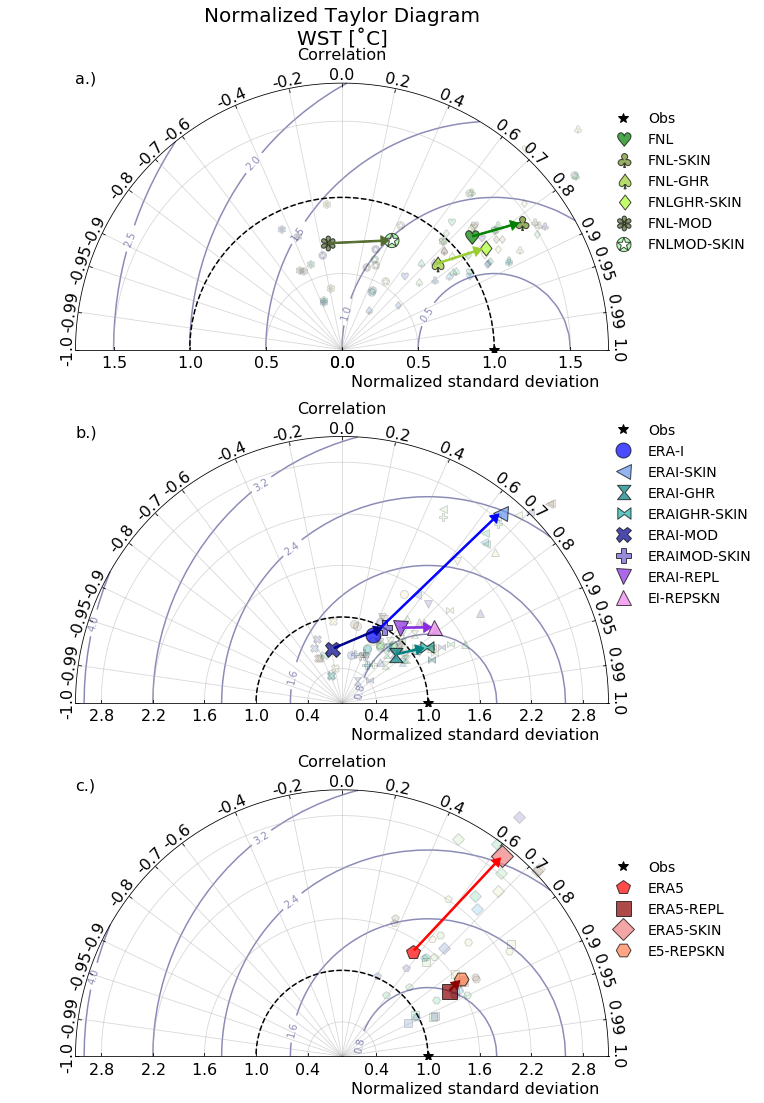

In [61]:
var = 'sst'
fig = plt.figure(figsize=(12,18))
plt.subplots_adjust(hspace=0.3)
#dia = TaylorDiagram(1.0, fig=fig, rect=122, extend=False,label='Obs',srange=[0.0,2.0])
#dia = TaylorDiagram(1.0, fig=fig, rect=224, extend=False,label='Obs',srange=[0.0,2.0])
if var != 'wdir':
    obs_var = var
    sim_var = vars_to_compare[var]
else:
    obs_var = '{}A'.format(var)
    sim_var = '{}A'.format(vars_to_compare[var])

extend = True

    
rect = 311
for coi,cases_of_interest in enumerate(cases_of_interest_chunks):
    if coi == 0:
        TD_max_r = 1.75
        stdevticks = np.arange(0.0,5.6,0.5)
    else:
        TD_max_r = 3.1
        stdevticks = np.arange(0.4,5.6,0.6)

    dia = TaylorDiagram(1.0, fig=fig, 
                        extend=extend,
                        rect=rect,
                        label='Obs',
                        normalize=True,
                        srange=[0.0,TD_max_r],
                        stdevticks=stdevticks,
                        labelsize=16)
    td_stats = {}
    sample_dict = {}

    for cc,case in enumerate(cases_of_interest):
        case_plt_dict = case_dict[case]['d0{}'.format(doms_of_interest[cc])]
        td_stats[case] = pd.DataFrame(index=TD_stns, columns=['std_norm','R2'], dtype=float) 

        for ss,stn in enumerate(TD_stns):

            obs = TD_obs_full[stn][obs_var]
            obs = obs.dropna(how='any',dim='datetime')
            sim = TD_wrf_buoys[case][sim_var].sel(station=stn)
            sim = sim.dropna(how='any',dim='datetime')

            ref_std = np.std(obs.data)
            sim_std = np.std(sim.data)

            r2,_ = pearsonr(sim, obs)

            if ss == 0: 
                obs_full = obs - np.nanmean(obs)
                sim_full = sim - np.nanmean(sim)
                #label_str = '_'.join(case.replace('_KF','').split('_')[1:])
                label_str = None
            else:
                obs_full = np.concatenate([obs_full,obs - np.nanmean(obs)])
                sim_full = np.concatenate([sim_full,sim - np.nanmean(sim)])
                label_str = None
            #print(case,stn,np.std(sim.data)/ref_std)
            if case_plt_dict['fill']:
                marker_c = stn_colors[stn]
                marker_e = 'k'
            else:
                marker_c = stn_colors[stn]
                marker_e = stn_colors[stn]

            td_stats[case].loc[stn,'std_norm'] = sim_std/ref_std
            td_stats[case].loc[stn,'R2'] = r2

            dia.set_ref(ref_std)

            dia.add_sample(np.std(sim.data), r2,
                           marker=case_plt_dict['marker'], ms=8, ls='',
                           mfc=marker_c, mec=marker_e, # Colors
                           label=label_str,
                           zorder=cc,alpha=0.15)

                #if cc == 0:
                #    txt_x = 0.38 + 0.17*stn_count
                #    txt_y = 0.12
                    #plt.text(txt_x,txt_y,'{0}'.format(stn),c=stn_colors[stn],size=22,ha='center')
                    #plt.text(txt_x,txt_y-0.08,'{0:2.1f}'.format(ref_std),size=18,ha='center')
                    #if ss == 0: plt.text(txt_x-0.1,txt_y-0.08,'ref. STD: ',size=18,ha='right')

        multimodal_mean = False

        if multimodal_mean:
            ref_std_full = np.std(obs_full)

            dia.add_sample(np.std(sim_full)/ref_std_full, np.corrcoef(sim_full,obs_full)[0,1],
                   marker=case_plt_dict['marker'], ms=15, ls='',
                   mfc=case_plt_dict['color'], mec='k', # Colors
                   label=case_plt_dict['name'],
                   zorder=cc+3,alpha=0.7)
        else:        
            td_stats[case]['angle'] = np.arccos(td_stats[case]['R2'])
            td_mean = td_stats[case].mean(axis=0)
            sample_dict[case] = dia.add_sample(td_mean['std_norm'], np.cos(td_mean['angle']),
                                            norm=False, # don't normalize this point
                                            marker=case_plt_dict['marker'], ms=15, ls='',
                                            mfc=case_plt_dict['color'], mec='k', # Colors
                                            label=case_plt_dict['name'],
                                            zorder=cc+3,alpha=0.7)

    connecting_cases = []
    for case in cases_of_interest:
        if ('SKNT' in case) or ('OVSK' in case):
            connecting_cases.append(case)

    for cc,case in enumerate(connecting_cases):
        if case in stn_pair_dict.keys():
            print(case,stn_pair_dict[case])
            arrow_origin = sample_dict[stn_pair_dict[case]].get_xydata()
            arrow_end    = sample_dict[case].get_xydata()
            arrow_xs,arrow_ys = np.squeeze(arrow_origin)
            arrow_xe,arrow_ye = np.squeeze(arrow_end)
            arrow_dx,arrow_dy = np.squeeze(arrow_end) - np.squeeze(arrow_origin)
            arrow_len_weight = 0.7
            if case == 'GFSR_YSU_CHRN_MOD_NOSK_3DOM':
                connection_style = 'arc3,rad=.5'
            else:
                connection_style = None
            arrow = patches.FancyArrowPatch((arrow_xs,arrow_ys),(arrow_xe,arrow_ye),connectionstyle=connection_style,
                                            color=case_dict[stn_pair_dict[case]]['d0{}'.format(doms_of_interest[cc])]['color'],
                                            arrowstyle='Simple, tail_width=1.5, head_width=10, head_length=8',zorder=100)
            dia.ax.add_patch(arrow)
    contours = dia.add_contours(levels=5, colors='midnightblue',alpha=0.50,zorder=1)
    dia.ax.clabel(contours, inline=1, fontsize=10, fmt='%.1f')
    dia.add_grid(alpha=0.5)
    plt.legend(frameon=False,fontsize=14,loc=(0.98,0.35),ncol=1)
    if coi == 0: plt.title('Normalized Taylor Diagram\n{}'.format(''.join(var_str_dict[var].split('\n')[0])),size=20,y=1.11)
    plt.text(-TD_max_r,TD_max_r,'{}.)'.format(ascii_lowercase[coi]),size=16)
    rect += 1
figname = '{}SST_SKIN_SST_TD'.format(save_dir)
if save_figs:
    plt.savefig('{}.png'.format(figname), bbox_inches = 'tight',pad_inches = 0.1)
    plt.savefig('{}.pdf'.format(figname), bbox_inches = 'tight',pad_inches = 0.1)
    print(figname)
plt.show()

# Unused plots:

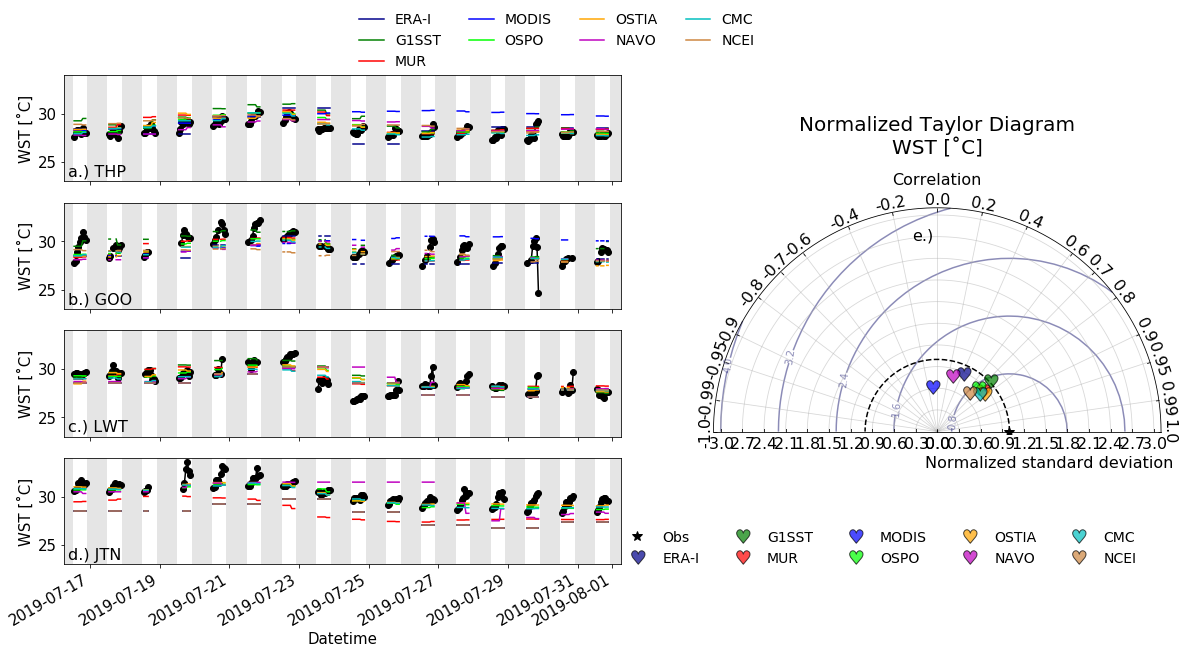

In [30]:
var           = 'sst'
show_each_sample = False

#var           = 'wspd'
#var_str       = 'Wind Speed\n[m s$^{-1}$]'
stns_for_plot = ['THP','GOO','LWT','JTN']
if var == 'wspd':
    ymin,ymax = 0,15
    ylabel = 'Wind Speed [m s$^{-1}$]'
if var == 'wdir':
    ymin,ymax = 0,0.5
if var == 'sst':
    ymin,ymax = 22,34
    ylabel = 'WST [˚C]'

if var != 'wdir':
    obs_var = var
    sim_var = vars_to_compare[var]

fig = plt.figure(figsize=(18,9))
gs1 = gridspec.GridSpec(len(stns_for_plot), 1)
gs1.update(left=0.05, right=0.48, wspace=0.05)
#ax1 = plt.subplot(gs1[0])
#ax2 = plt.subplot(gs1[1])
#ax3 = plt.subplot(gs1[2])
#ax4 = plt.subplot(gs1[3])

for ss,stn in enumerate(stns_for_plot):
    ax1 = plt.subplot(gs1[ss])
    

    obs = TD_obs_full[stn][obs_var]


    ref_std = np.std(obs.dropna(how='any',dim='datetime').data)

    for cc,case in enumerate(cases_of_interest):
        case_plt_dict = case_dict[case]['d0{}'.format(doms_of_interest[cc])]
        sim = TD_wrf_buoys[case][sim_var].sel(station=stn)

        if cc == 0:
            obs_plt = obs#.dropna(how='any',dim='datetime')
            if len(obs.dropna(how='any',dim='datetime')) > 2:
                obs_plt.plot(ax=ax1,c='k',marker='o')
        if len(sim.dropna(how='any',dim='datetime')) > 2:
            sim_plt = sim#.dropna(how='any',dim='datetime')
            sim_plt.plot(ax=ax1,label='{}'.format(case_plt_dict['name']),c=case_plt_dict['color'])
    ax1.set_title('')
    ax1.set_ylabel(var_str_dict[var],size=15)
    if ss == 3:
        ax1.set_xlabel('Datetime',size=15)
        ax1.tick_params(labelsize=15)
    else:
        ax1.set_xlabel('')
        ax1.tick_params(labelbottom=False,labelsize=15)
    plt_start_date = pd.to_datetime(obs.datetime.values[0])
    plt_end_date = pd.to_datetime(obs.datetime.values[-1])
    for day in pd.date_range(start=plt_start_date - pd.to_timedelta(1,'d'), end=plt_end_date):
        night_s = pd.to_datetime('{0:04d}-{1:02d}-{2:02d} {3:02d}:00'.format(day.year,day.month,day.day,night_hour_s))
        night_e = pd.to_datetime('{0:04d}-{1:02d}-{2:02d} {3:02d}:00'.format(day.year,day.month,day.day,night_hour_e)) + pd.Timedelta(1,'d')
        ax1.fill_betweenx([-100,400],night_s,night_e,facecolor='k',alpha=0.1)   
    ymin,ymax = 23,34
    txt_y = ymin + 0.02*(ymax-ymin)
    if stn == 'DEB': txt_y = ymin + 0.82*(ymax-ymin)
    ax1.text(obs.datetime.data[3],txt_y,'{}.) {}'.format(ascii_lowercase[ss],stn),va='bottom',ha='left',size=16)
    ax1.set_ylim(ymin,ymax)
    ax1.set_xlim(sim.datetime.data[0],sim.datetime.data[-1])
    if ss == 0: ax1.legend(frameon=False,ncol=4,loc=(0.52,1.01),fontsize=14,handlelength=1.75)

#dia = TaylorDiagram(1.0, fig=fig, rect=122, extend=False,label='Obs',srange=[0.0,2.0])
#dia = TaylorDiagram(1.0, fig=fig, rect=224, extend=False,label='Obs',srange=[0.0,2.0])
if var != 'wdir':
    obs_var = var
    sim_var = vars_to_compare[var]
else:
    obs_var = '{}A'.format(var)
    sim_var = '{}A'.format(vars_to_compare[var])

extend = False
if var == 'pres':
    TD_max_r = 1.3
elif var == 'temp':
    TD_max_r = 1.5
elif var == 'wspd':
    TD_max_r = 1.5
elif var == 'sst':
    TD_max_r = 3.1
    extend = True
else:
    TD_max_r = 1.5
    
dia = TaylorDiagram(1.0, fig=fig, 
                    extend=extend,
                    rect=122,
                    label='Obs',
                    normalize=True,
                    srange=[0.0,TD_max_r],
                    stdevticks=np.arange(0.0,5.6,0.3),
                    labelsize=16)
td_stats = {}


for cc,case in enumerate(cases_of_interest):
    case_plt_dict = case_dict[case]['d0{}'.format(doms_of_interest[cc])]
    td_stats[case] = pd.DataFrame(index=TD_stns, columns=['std_norm','R2'], dtype=float) 

    for ss,stn in enumerate(TD_stns):

        obs = TD_obs_full[stn][obs_var]
        obs = obs.dropna(how='any',dim='datetime')
        sim = TD_wrf_buoys[case][sim_var].sel(station=stn)
        sim = sim.dropna(how='any',dim='datetime')

        ref_std = np.std(obs.data)
        sim_std = np.std(sim.data)

        r2,_ = pearsonr(sim, obs)

        if ss == 0: 
            obs_full = obs - np.nanmean(obs)
            sim_full = sim - np.nanmean(sim)
            #label_str = '_'.join(case.replace('_KF','').split('_')[1:])
            label_str = None
        else:
            obs_full = np.concatenate([obs_full,obs - np.nanmean(obs)])
            sim_full = np.concatenate([sim_full,sim - np.nanmean(sim)])
            label_str = None
        #print(case,stn,np.std(sim.data)/ref_std)
        marker_c = stn_colors[stn]
        marker_e = 'k'


        td_stats[case].loc[stn,'std_norm'] = sim_std/ref_std
        td_stats[case].loc[stn,'R2'] = r2

        if show_each_sample:
            dia.set_ref(ref_std)
            dia.add_sample(np.std(sim.data), r2,
                           marker=case_plt_dict['marker'], ms=8, ls='',
                           mfc=marker_c, mec=marker_e, # Colors
                           label=label_str,
                           zorder=cc,alpha=0.2)


    multimodal_mean = False

    if multimodal_mean:
        ref_std_full = np.std(obs_full)

        dia.add_sample(np.std(sim_full)/ref_std_full, np.corrcoef(sim_full,obs_full)[0,1],
               marker=case_plt_dict['marker'], ms=15, ls='',
               mfc=case_plt_dict['color'], mec='k', # Colors
               label=case_plt_dict['name'],
               zorder=cc+3,alpha=0.7)
    else:        
        td_stats[case]['angle'] = np.arccos(td_stats[case]['R2'])
        td_mean = td_stats[case].mean(axis=0)
        dia.add_sample(td_mean['std_norm'], np.cos(td_mean['angle']),
               norm=False, # don't normalize this point
               marker=case_plt_dict['marker'], ms=15, ls='',
               mfc=case_plt_dict['color'], mec='k', # Colors
               label=case_plt_dict['name'],
               zorder=cc+3,alpha=0.7)
contours = dia.add_contours(levels=5, colors='midnightblue',alpha=0.50,zorder=1)
dia.ax.clabel(contours, inline=1, fontsize=10, fmt='%.1f')
dia.add_grid(alpha=0.5)
plt.legend(frameon=False,fontsize=14,loc=(-0.2,-0.60),ncol=5)
plt.title('Normalized Taylor Diagram\n{}'.format(''.join(ylabel.split('\n')[0])),size=20,y=1.2)
plt.text(-0.05,2.65,'e.)',size=16,ha='right')
figname = '{}ICBC_TD_SST'.format(save_dir)
if save_figs:
    plt.savefig('{}.png'.format(figname), bbox_inches = 'tight',pad_inches = 0.1)
    plt.savefig('{}.pdf'.format(figname), bbox_inches = 'tight',pad_inches = 0.1)
    print(figname)
plt.show()

In [137]:
cases_of_interest = []
for case in cases:
    if 'NOFL_SKNT' in case:
        cases_of_interest.append(case)
doms_of_interest  = [3]*len(cases_of_interest)

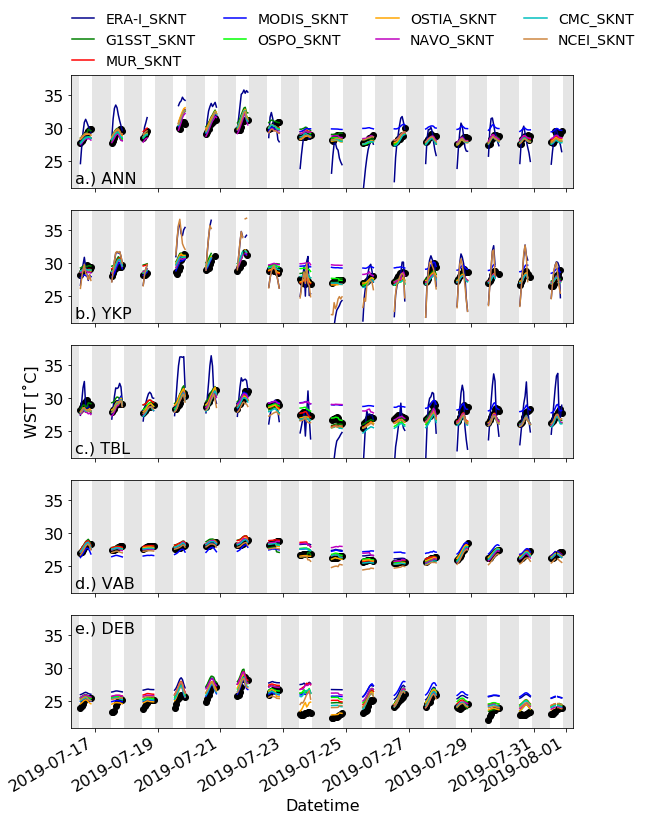

In [32]:
stns_for_plot = ['ANN','YKP','TBL','VAB','DEB']
var = 'sst'
var_str = 'WST [˚C]'

if var != 'wdir':
    obs_var = var
    sim_var = vars_to_compare[var]
else:
    obs_var = '{}A'.format(var)
    sim_var = '{}A'.format(vars_to_compare[var])

fig,ax = plt.subplots(len(stns_for_plot),sharex=True,figsize=(9,12))

lines = []
for ss,stn in enumerate(stns_for_plot):

    obs = TD_obs_full[stn][obs_var]


    ref_std = np.std(obs.dropna(how='any',dim='datetime').data)

    for cc,case in enumerate(cases_of_interest):
        case_plt_dict = case_dict[case]['d0{}'.format(doms_of_interest[cc])]
        sim = TD_wrf_buoys[case][sim_var].sel(station=stn)

        if cc == 0:
            obs_plt = obs#.dropna(how='any',dim='datetime')
            if len(obs.dropna(how='any',dim='datetime')) > 2:
                obs_plt.plot(ax=ax[ss],c='k',marker='o')
        if len(sim.dropna(how='any',dim='datetime')) > 2:
            sim_plt = sim#.dropna(how='any',dim='datetime')
            lines += sim_plt.plot(ax=ax[ss],label='{}'.format(case_plt_dict['name']),c=case_plt_dict['color'])
        if ss == 0:
            if case == 'ERAI_YSU_CHRN_MOD_NOSK_3DOM':
                ax[0].plot(sim.datetime.data[0],0.0, color='w', alpha=0, label=' ')
                ax[0].plot(sim.datetime.data[0],0.0, color='w', alpha=0, label=' ')
    ax[ss].set_ylabel(var_str_dict[var],size=16)
    if ss == len(TD_stns) - 1:
        ax[ss].set_xlabel('Datetime',size=16)
    else:
        ax[ss].set_xlabel('')
    if ss == 0:
        ax[ss].set_title(var,size=18)
    else:
        ax[ss].set_title('')

    if var == 'wspd':
        ymin,ymax = 0,15
    if var == 'wdir':
        ymin,ymax = 0,0.5
    if var == 'sst':
        ymin,ymax = 21,38
    if var == 'temp':
        ymin,ymax = 15,40
    if var == 'u':
        ymin,ymax = -10,10
    if var == 'v':
        ymin,ymax = -10,10
    if var == 'pres':
        ymin,ymax = 1005,1030

    ax[ss].set_yticks(np.arange(5,46,5))
    ax[ss].set_ylim(ymin,ymax)
    ax[ss].tick_params(labelsize=16)
    if ss == 2:
        ax[ss].set_ylabel(var_str,size=16)
    else:
        ax[ss].set_ylabel('')

    ax[ss].set_xlim(sim.datetime.data[0],sim.datetime.data[-1])
    txt_y = ymin + 0.02*(ymax-ymin)
    if stn == 'DEB': txt_y = ymin + 0.82*(ymax-ymin)
    ax[ss].text(obs.datetime.data[3],txt_y,'{}.) {}'.format(ascii_lowercase[ss],stn),va='bottom',ha='left',size=16)
    plt_start_date = pd.to_datetime(obs.datetime.values[0])
    plt_end_date = pd.to_datetime(obs.datetime.values[-1])
    for day in pd.date_range(start=plt_start_date - pd.to_timedelta(1,'d'), end=plt_end_date):
        night_s = pd.to_datetime('{0:04d}-{1:02d}-{2:02d} {3:02d}:00'.format(day.year,day.month,day.day,night_hour_s))
        night_e = pd.to_datetime('{0:04d}-{1:02d}-{2:02d} {3:02d}:00'.format(day.year,day.month,day.day,night_hour_e)) + pd.Timedelta(1,'d')
        ax[ss].fill_betweenx([-100,400],night_s,night_e,facecolor='k',alpha=0.1)


ax[0].legend(frameon=False,ncol=4,loc=(-0.01,1.01),fontsize=14,handlelength=1.6)


ax[0].set_title('')
ax[-1].set_xlabel('Datetime',size=16)
figname = '{}AuxSST_5panel'.format(save_dir)
if save_figs:
    plt.savefig('{}.png'.format(figname), bbox_inches = 'tight',pad_inches = 0.1)
    plt.savefig('{}.pdf'.format(figname), bbox_inches = 'tight',pad_inches = 0.1)
    print(figname)
plt.show()


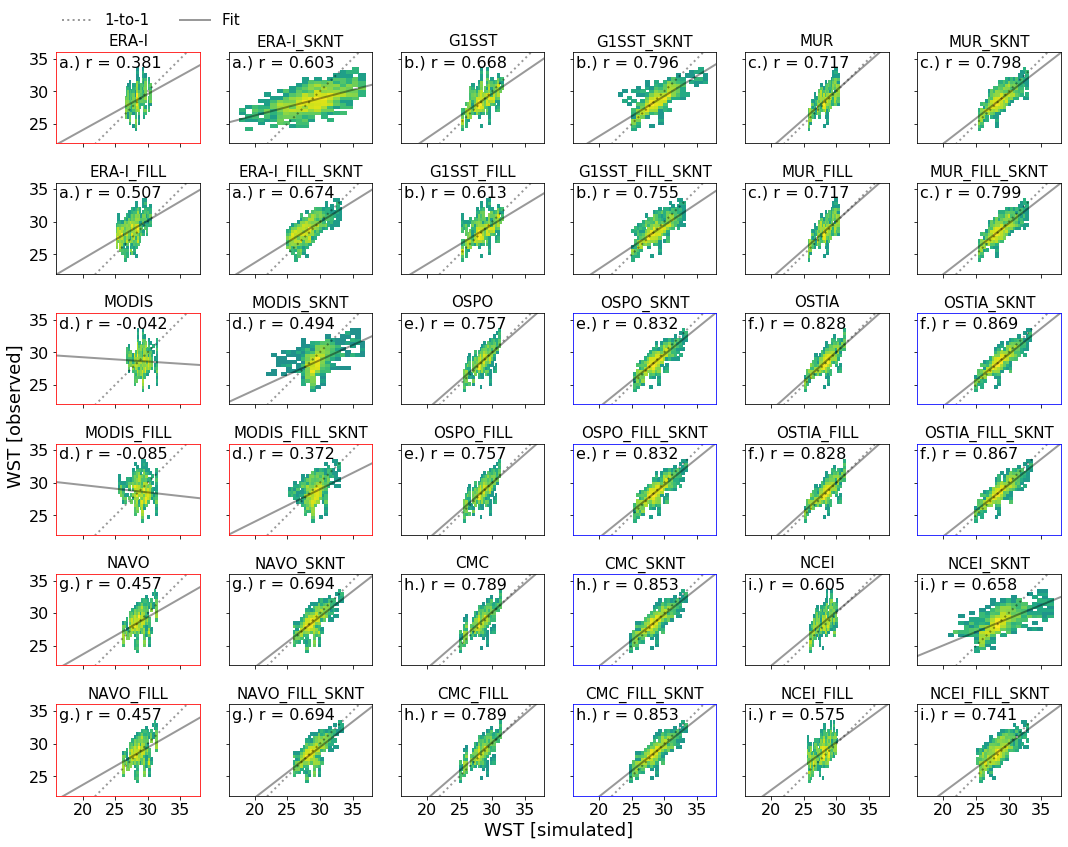

In [37]:
obs_var = var
sim_var = vars_to_compare[var]
if var == 'sst'    : var_str = 'WST'
if var == 'wspd'   : var_str = 'Wind Speed'
if var == 'temp'   : var_str = '2 m Temperature'
if var == 'pres'   : var_str = 'Surface Pressure'
if var == 't_diff' : var_str = '∆T'
fig,ax = plt.subplots(nrows=6,ncols=6,figsize=(18,14),sharey=True,sharex=True)
row = 0
col = 0
case_performance_dict = {}
case_count = 0
row_start = 0
col_start = 0

for cc,case in enumerate(cases_of_interest):

    for ss,stn in enumerate(TD_stns):

        obs = TD_obs_full[stn][obs_var]
        obs = obs.dropna(how='any',dim='datetime')

        case_plt_dict = case_dict[case]['d0{}'.format(doms_of_interest[cc])]
        sim = TD_wrf_buoys[case][sim_var].sel(station=stn)
        sim = sim.dropna(how='any',dim='datetime')

        varA = sim.data
        varB = obs.data

        if ss == 0:
            varA_f = varA
            varB_f = varB
        else:
            varA_f = np.concatenate((varA_f,varA))
            varB_f = np.concatenate((varB_f,varB))
    if (len(varA_f) == len(varB_f)) and (len(varA_f) > 2):
        slope, intercept, r_value, p_value, std_err = stats.linregress(varA_f, varB_f)
        x2d,y2d,hist2d = create_2dHistogram(varA_f,varB_f,20,20)

        ax[row,col].pcolormesh(x2d,y2d, hist2d,norm=colors.LogNorm(vmin=1e-2,vmax=hist2d.max()),rasterized=True)




    ref_x = np.arange(-1000,1001)
    if cc == 0:
        line_lbl1 = '1-to-1'
        line_lbl2 = 'Fit'
    else:
        line_lbl1 = None
        line_lbl2 = None
        
    ymin,ymax = 22,36
    xmin,xmax = 16,38
    xtick_min,xtick_max,xtick_int = 10,42,5
    ytick_min,ytick_max,ytick_int = 10,42,5
    
    ax[row,col].plot(ref_x,ref_x,c='k',lw=2.0,alpha=0.4,ls=':',label=line_lbl1)
    ax[row,col].plot(ref_x,slope*ref_x + intercept,c='k',lw=2.0,alpha=0.4,label=line_lbl2)
    if cc == 0: ax[0,0].legend(frameon=False,loc=(0.0,1.2),fontsize=15,ncol=2)
    ax[row,col].text(xmin+0.02*(xmax-xmin),ymin+0.97*(ymax-ymin),'{1}.) r = {0:4.3f}'.format(
                                                                r_value,ascii_lowercase[case_count]), size=16,va='top')
    ax[row,col].set_title(case_plt_dict['name'],size=15)
    ax[row,col].tick_params(labelsize=16)

    
    
    ax[row,col].set_xticks(np.arange(xtick_min,xtick_max+1,xtick_int))
    ax[row,col].set_yticks(np.arange(ytick_min,ytick_max+1,ytick_int))
    ax[row,col].set_xlim(xmin,xmax)
    ax[row,col].set_ylim(ymin,ymax)
    ax[row,col].set_aspect('equal')
    
    
    case_performance_dict[case] = r_value

    # Row, col logic - - - - - - - - - - - - - - - - - 
    if (((cc+1)/4.0 - np.round((cc+1)/4.0)) == 0.0):
        case_count += 1
        col_start += 2

        if (((case_count)/3.0 - np.round((case_count)/3.0)) == 0.0):
            row_start += 2
            col_start = 0
        row = row_start
        col = col_start
    else:

        col += 1
        if col == col_start + 2:
            col = col_start
            row += 1
        if row == row_start + 2:
            row = row_start
    # - - - - - - - - - - - - - - - - - - - - - - - - - 


sorted_performance = dict(sorted(case_performance_dict.items(), key=lambda x: x[1]))
row = 0
col = 0
case_count = 0
row_start = 0
col_start = 0
for cc,case in enumerate(cases_of_interest):
    if case in list(sorted_performance.keys())[:6]:
        plt.setp(ax[row,col].spines.values(), color='r')
    elif case in list(sorted_performance.keys())[-6:]:
        plt.setp(ax[row,col].spines.values(), color='b')
    # Row, col logic - - - - - - - - - - - - - - - - - 
    if (((cc+1)/4.0 - np.round((cc+1)/4.0)) == 0.0):
        case_count += 1
        col_start += 2

        if (((case_count)/3.0 - np.round((case_count)/3.0)) == 0.0):
            row_start += 2
            col_start = 0
        row = row_start
        col = col_start
    else:

        col += 1
        if col == col_start + 2:
            col = col_start
            row += 1
        if row == row_start + 2:
            row = row_start
    # - - - - - - - - - - - - - - - - - - - - - - - - - 
#ax[4,0].set_visible(False)
#ax[4,1].set_visible(False)
ax[3,0].set_ylabel('{} [observed]'.format(var_str),size=18,y=1.3)
ax[5,2].set_xlabel('{} [simulated]'.format(var_str),size=18,x=1.1)

figname = '{}SST_SKIN_2Dhist_equal'.format(save_dir)
if save_figs:
    plt.savefig('{}.png'.format(figname), bbox_inches = 'tight',pad_inches = 0.1)
    plt.savefig('{}.pdf'.format(figname), bbox_inches = 'tight',pad_inches = 0.1)
    print(figname)
plt.show()


# Error/Bias plots:

### Bias is not super important here... these plots are more interesting than the TDs, but not as useful

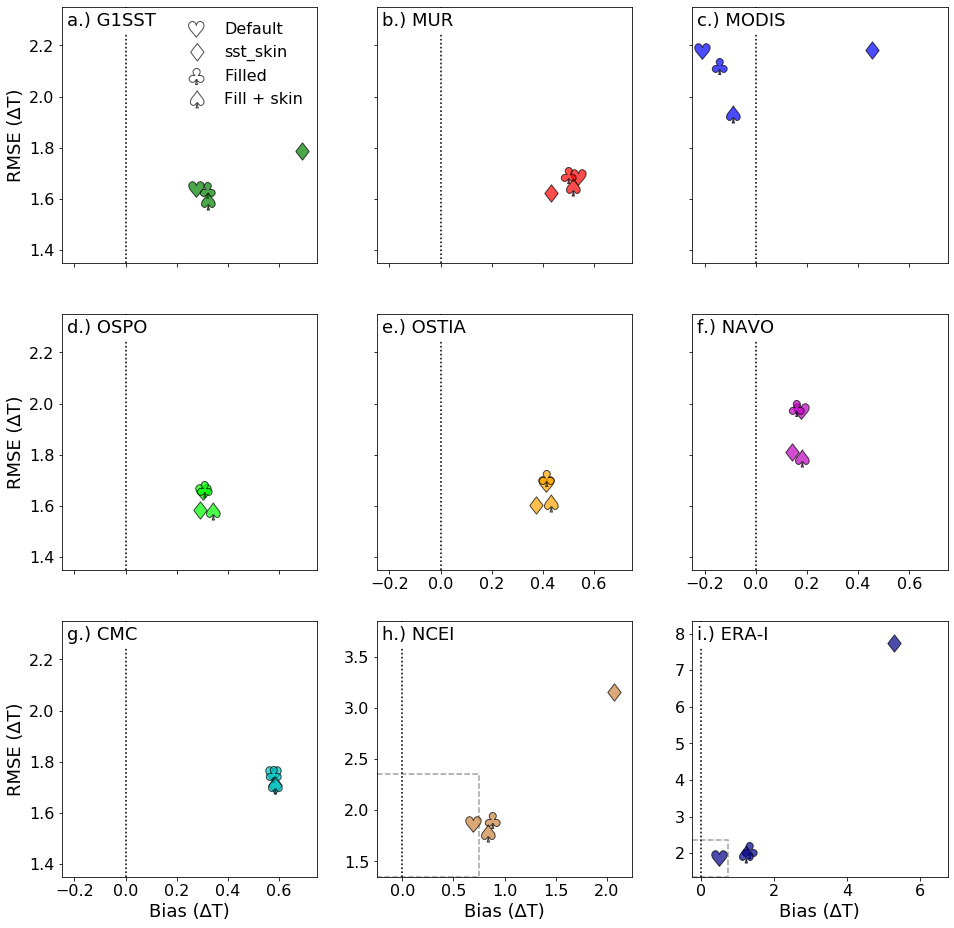

In [56]:
var = 'dT'
fig,ax = plt.subplots(ncols=3,nrows=3,figsize=(16,16))#,sharex=True,sharey=True)

extend = False
show_arrows = False

row = 0
col = 0
case_prev = 'G1SST'
tdax = 331
td_stats = {}
sample_dict = {}
case_count = 0
show_lbl = True

for cc,case in enumerate(plt_order_full):
    case_plt_dict = case_dict[case]['d0{}'.format(doms_of_interest[cc])]

    if (case.split('_')[0] != case_prev):
        case_count += 1

        show_lbl = True
        if cc > 20:
            label_std = True
        else:
            label_std = False
            
        if 'DEFLT' in case:
            lbl_y = 0.033
            lbl_x = 0.39
        else:
            lbl_y = 0.025
            lbl_x = 0.025


        case_prev = case.split('_')[0]
        col += 1
        if col > 2:
            col = 0
            row += 1

    obs = tdiff_obs
    obs = obs.dropna(how='any',dim='datetime')
    sim = tdiff_wrf[case+'_d03']
    sim = sim.dropna(how='any',dim='datetime')

    del_t_bias = (sim - obs).mean().data
    del_t_rmse = (((sim - obs)**2).mean().data)**0.5

    ax[row,col].scatter(del_t_bias,del_t_rmse,
                        marker=case_plt_dict['marker'], s=300,
                        fc=case_plt_dict['color'], ec='k', # Colors
                        #label=case_plt_dict['name'],
                        zorder=cc+3,alpha=0.7)
    ax[row,col].set_aspect('equal')
    ymin,ymax = 1.35,2.35
    xmin,xmax = -0.25,0.75
    if 'DEFLT' in case:
        ax[row,col].plot([xmin,xmax,xmax,xmin,xmin],
                         [ymax,ymax,ymin,ymin,ymax],
                         c='k',alpha=0.1,ls='--')
        ymin,ymax = ymin,ymin+7
        xmin,xmax = xmin,xmin+7
    elif 'NCEIA' in case:
        ax[row,col].plot([xmin,xmax,xmax,xmin,xmin],
                         [ymax,ymax,ymin,ymin,ymax],
                         c='k',alpha=0.1,ls='--')
        ymin,ymax = ymin,ymin+2.5
        xmin,xmax = xmin,xmin+2.5
    ax[row,col].set_ylim(ymin,ymax)
    ax[row,col].set_xlim(xmin,xmax)
    ax[row,col].axvline(0.0,ls=':',c='k',alpha=0.4)
    ax[row,col].tick_params(labelsize=16)
    if show_lbl:
        ax[row,col].text(0.02,0.98,'{}.) {}'.format(ascii_lowercase[case_count],case_plt_dict['name']),size=18,
                    ha='left',va='top',bbox={'fc':'w','ec':'none'},
                    transform=ax[row,col].transAxes,
                    zorder=1000)
        show_lbl = False
    if row < 2:
        if not ((col >= 1) & (row == 1)):
            ax[row,col].tick_params(labelbottom=False,labelsize=16)
    if col > 0:
        if not ((col >= 1) & (row == 2)):
            ax[row,col].tick_params(labelleft=False,labelsize=16)
            
    if col == 0: ax[row,col].set_ylabel('RMSE (∆T)',size=18)
    if row == 2: ax[row,col].set_xlabel('Bias (∆T)',size=18)
        
markers = ['$♥$','$♦$','$\\clubsuit$','$\\spadesuit$']
leg_labels = ['Default','sst_skin','Filled','Fill + skin']
for mm in range(0,4):
    ax[0,0].scatter(-10,-10,
                    marker=markers[mm], s=300,
                    c='none', ec='k', # Colors
                    label=leg_labels[mm],
                    zorder=cc+3,alpha=0.7)
ax[0,0].legend(frameon=False,fontsize=16)
plt.show()